## Part 1-1

### Task: select 3 centrality measures for comparing which nodes are the most crucial ones in the London underground system, including degree centrality, (Topological) closeness centrality,betweenness centrality

#### 1.1 Import packages

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import json
import re
from shapely.geometry import Point, LineString #this library is for manipulating geometric objects, and it is what geopandas uses to store geometries
from scipy.spatial import distance

#### 1.2 Read in data set

In [2]:
london_OD_AMpeak = pd.read_csv('london_flows.csv')#tube network in London and relevant useful information
london_OD_AMpeak.head() #flows: group by origin and destination station and sum the flows
#read in London underground data using geopandas
stations = gpd.read_file('tfl_stations.json')
lines = gpd.read_file('tfl_lines.json')
#project underground data to British National Grid
stations = stations.to_crs(epsg = 27700)
lines = lines.to_crs(epsg = 27700)

#### 1.3 Outflow and inflow histogram of London underground

In [3]:
# #sanity check and see the highest and lowest flows in and out flows
# outflows = london_OD_AMpeak.groupby('station_origin').sum()
# outflows.sort_values('flows').head(10)
# outflows.sort_values('flows').tail(10)
# inflows = london_OD_AMpeak.groupby('station_destination').sum()
# inflows.sort_values('flows').head(10)
# inflows.sort_values('flows').tail(10)
# #plot this as a histogram
# bin_size=100
# fig, ax = plt.subplots(2,1,figsize=(12,10))
# ax[0].hist(outflows['flows'], bins=int(outflows.max()[0]/bin_size))
# ax[0].set_xlabel('London am peak outflows', fontsize = 15)
# ax[0].set_ylabel("Count", fontsize= 15)
# ax[0].grid(True)

# ax[1].hist(inflows['flows'], bins=int(inflows.max()[0]/bin_size))
# ax[1].set_xlabel('London am peak inflows', fontsize = 15)
# ax[1].set_ylabel("Count", fontsize= 15)
# ax[1].grid(True)
# plt.show()

#### 1.4 London underground data -> stations

In [4]:
#get all station names
station_names = {row.id: row['name'] for i, row in stations.iterrows()}
#clean station names
for k, v in station_names.items():
    if k == 'none':
        continue
    cleaned_name = re.sub('\sLU\s?|\sLO\s?|\sNR\s?|\sTf[lL]\s?|\sDLR\s?|\s\(.*\)', '', v)
    #note that bank and monument are enconded as one station in our TFL data, so we will do the same
    if cleaned_name in ['Bank', 'Monument']:
        cleaned_name = 'Bank and Monument'
    station_names[k] = cleaned_name
stations['name'] = stations['id'].apply(lambda x: station_names[x])

## we will plot all the stations with multiple points to check there are no errors
# fig, ax = plt.subplots(figsize = (30,30))
# ax.set_aspect("equal")
# ax.axis('off')
# ax.margins(0.2)
# color = iter(cm.rainbow(np.linspace(0, 1, 29)))
# stations.plot(ax=ax, color='grey', markersize=0.5)
# for i, group in stations.groupby('name'):
#     if len(group)>1:
#         group.plot(ax=ax, color = next(color), markersize=15)
# plt.show()

In [5]:
#get position of stations as mean of x, y of stations
#create empty dict to store list of coordinates
pos = {}
#iterate through the stations
for i, station in stations.iterrows():
    xy = station.geometry.coords[0]    
    #if station already in dict add coordinate to coordinate list
    if station['name'] in pos.keys():
        pos[station['name']].extend([xy])
    #if station is not in the dict add station to dict and set first coordinate in list
    else:
        pos[station['name']] = [xy]
#iterate through our dict and replace coordinate list with mean value
for k, v in pos.items():
    #we set axis to 0 to make sure to take mean of x and y coordinates
    pos[k] = np.mean(v, axis=0)
#set new geometry
stations['geometry'] = stations['name'].apply(lambda x: Point(pos[x]))
#check plot to make sure there are no errors
# stations.plot(markersize=2)

#### 1.5 London underground data -> lines

In [6]:
#get all line types as a list and subset geoms by lines
line_names  = lines.lines.apply(lambda x: [x['name'] for x in json.loads(x)] )
line_names = list(set([item for sublist in line_names for item in sublist]))
line_names
# # check the data for each line
# for line in line_names:
#     #I'm removing thameslink 6tph line because there are not corresponding stations in station file
#     if line == 'Thameslink 6tph line':
#         continue
#     fig, ax = plt.subplots(figsize = (7,7))
#     fig.suptitle(f'line: {line}')
#     ax.set_aspect("equal")
#     ax.axis('off')
#     ax.margins(0.1)
#     temp_lines = lines[lines.lines.str.contains(line)]
#     base = temp_lines.plot(ax=ax)
#     temp_stations = stations[stations.lines.str.contains(line)]
#     temp_stations.plot(ax=base, markersize=20)
#     plt.show()
#merge East London line and London Overground since they are one line
lines.lines = lines.lines.str.replace('East London', 'London Overground')
stations.lines = stations.lines.str.replace('East London', 'London Overground')
#exclude the lines that we are not going to use
excluded_lines = ['Thameslink 6tph line', 'East London', 'Crossrail 2', 'Emirates Air Line', 'Crossrail', 'Tramlink']


#### 1.6 create seperate graphs for each line and then join

In [7]:
#create an empty dict to hold our geometric graphs
geometric_graphs = {}

#iterate through each line individually
for line_name in line_names:
    #skip lines that we won't be using
    if line_name in excluded_lines :
        continue
    print(line_name)
    
    #subset our line and station files for the ones the belong to a specific line
    temp_lines = lines[lines.lines.str.contains(line_name)]
    temp_stations = stations[stations.lines.str.contains(line_name)]
    
    #create empty graph
    G= nx.Graph()
    
    #iterate through our line geometries
    for i, line in temp_lines.iterrows():
        #get list of coordinates that define our line
        _l = list(line.geometry.coords)

        #add coordinates as edges
        G.add_edges_from(list(zip(_l,_l[1:])))
    
    #remove any self loops
    G.remove_edges_from(nx.selfloop_edges(G))
    
    #the position of the node is the name of the node
    #let's extract this to plot our graph
    pos = {n: n for n in G.nodes()}
    
    # get degree one nodes
    D = nx.degree(G)
    k1 = [node for node,degree in D if degree==1]
#     #plot our graph and all degree one nodes
#     nx.draw(G, pos=pos, node_size=0.5, node_color='grey')
#     nx.draw_networkx_nodes(G, pos=pos, nodelist=k1, node_color='red', node_size=8)
#     plt.show()
    
    #get distance between all points of 1-degree, this will be a matrix
    dist = distance.cdist(k1, k1)
    
    #add edges between points that are close
    for j in range(dist.shape[0]-1):
        temp = dist[j][j+1:]
        #get index of closest node
        i_min = np.argmin(temp)
        if dist[j][i_min+j+1]<50:
            G.add_edge(k1[j],k1[i_min+j+1])
    
    #recalculate degree
    D = nx.degree(G)
    k1 = [node for node,degree in D if degree==1]
#     #plot new graph
#     nx.draw(G, pos=pos, node_size=0.5, node_color='grey')
#     nx.draw_networkx_nodes(G, pos=pos, nodelist=k1, node_color='red', node_size=8)
#     plt.show()
    print(nx.number_connected_components(G))
    #store graph in dictionary
    geometric_graphs[line_name] = G


Victoria
1
Circle
1
DLR
1
Jubilee
1
Northern
1
District
1
TfL Rail
1
Hammersmith & City
1
Central
1
London Overground
3
Waterloo & City
1
Metropolitan
1
Piccadilly
1
Bakerloo
1


In [8]:
#create a dataframe with all geometries from all valid lines

edge_list = []
def _has_ids(k):
    #helper function: to check if line contains id of start and end station
    if ('start_sid' in k.keys()) and ('end_sid' in k.keys()):
        return True
    else:
        return False

#iterate through each line seperately 
for line_name in line_names:
    if line_name in excluded_lines :
        continue
        
    #subset lines and stations
    temp_lines = lines[lines.lines.str.contains(line_name)]
    temp_stations = stations[stations.lines.str.contains(line_name)]
    
    #for each line in our subset dataframe get each origin and destination pair
    for i, line in temp_lines.iterrows():
        for k in json.loads(line.lines):
            if k['name'] == line_name:
                if _has_ids(k):
                    #get start and end station ids
                    start_id = k['start_sid']
                    end_id = k['end_sid']

                    #get info of start and end station
                    start_station = temp_stations[(temp_stations.id == start_id) | (temp_stations.altmodeid == start_id)].values
                    end_station = temp_stations[(temp_stations.id == end_id) | (temp_stations.altmodeid == end_id)].values
                    
                    #if no matching station exist, let's just take the starting and ending coordinate of the line for now
                    if len(start_station) >= 1 and len(end_station) >=1:
                        s_geom = start_station[0][-1].coords[0]
                        e_geom = end_station[0][-1].coords[0]
                        edge_list.append({
                            'line_name': line_name,
                            'start_id': start_id,
                            'end_id': end_id,
                            'geometry': LineString([s_geom, e_geom])
                        })
#turn our dictionary list into a geopandas df to quickly plot and sanity check our work
edge_gdf = gpd.GeoDataFrame(edge_list)
edge_gdf.crs = lines.crs
# edge_gdf.plot()
edge_gdf.head()

,line_name,start_id,end_id,geometry
0,Victoria,940GZZLUBXN,940GZZLUSKW,"LINESTRING (531054.149 175421.931, 530496.858 ..."
1,Victoria,940GZZLUSKW,940GZZLUVXL,"LINESTRING (530496.858 176472.930, 530420.272 ..."
2,Victoria,940GZZLUVXL,940GZZLUPCO,"LINESTRING (530420.272 177894.386, 529723.571 ..."
3,Victoria,940GZZLUPCO,940GZZLUVIC,"LINESTRING (529723.571 178312.661, 528989.161 ..."
4,Victoria,940GZZLUVIC,940GZZLUGPK,"LINESTRING (528989.161 179124.963, 528968.086 ..."


#### 1.7 Add all information back to the graph

In [9]:
### Add geometry information back into the graph
for line_name in line_names:
    if line_name in excluded_lines :
        continue
    temp_lines = edge_gdf[edge_gdf.line_name == line_name]
    temp_stations = stations[stations.lines.str.contains(line_name)]
    
#     #plot our lines so we can check them
#     fig, ax = plt.subplots(figsize = (7,7))
#     fig.suptitle(f'line: {line_name}')
#     ax.set_aspect("equal")
#     ax.axis('off')
#     ax.margins(0.1)
    
#     base = temp_lines.plot(ax=ax, color='grey')
#     temp_stations.plot(ax=base, markersize=20, color='red')
#     plt.show()
    
    #add real geometry back
    for i, edge in temp_lines.iterrows():
        #get start and end of line coordinates
        start = edge.geometry.coords[0]
        end = edge.geometry.coords[-1]
        
        #get all the coordinates in our geometric graph
        nodes = list(geometric_graphs[line_name].nodes)
        
        #find nearest node in graph to origin and destination
        s_dist = distance.cdist([start], nodes)[0]
        s_i = np.argmin(s_dist)
        source= nodes[s_i]
        
        t_dist = distance.cdist([end], nodes)[0]
        t_i = np.argmin(t_dist)
        target= nodes[t_i]
        
        #get shortest path
        sp = nx.shortest_path(geometric_graphs[line_name], source, target)
        
        geometry = LineString([start] + sp + [end])
        edge_gdf.loc[i, 'geometry'] = geometry

edge_gdf['length'] = edge_gdf.geometry.length #store the length of the real geometry
#replace the ids with the actual name
station_names_2 = {row.altmodeid: row['name'] for i, row in stations.iterrows() if row.altmodeid != None}
station_names.update(station_names_2)
edge_gdf['start_id'] = edge_gdf['start_id'].apply(lambda x: station_names[x])
edge_gdf['end_id'] = edge_gdf['end_id'].apply(lambda x: station_names[x])

#### 1.8 create network

In [10]:
G = nx.from_pandas_edgelist(edge_gdf, source = 'start_id', target='end_id', edge_attr=['length', 'line_name'])

#plot the network
pos = {row['name']: row.geometry.coords[0] for i, row in stations.iterrows() if row['name'] in G.nodes()}
Gcc = nx.connected_components(G)
for n in Gcc:
    G_sub = G.subgraph(n)
    lines = [data['line_name'] for u,v, data in G_sub.edges(data=True)]
    print(set(lines))
#     nx.draw(G_sub, pos, node_size=4)
#     plt.show() #ignore the straight lines between two stations, they are acceptable
nx.set_node_attributes(G, pos, 'coords') #save position to graph    

# sanity check the network
#check that all distances are greater or equal to euclidean distance
# for u,v, data in G.edges(data=True):
#     assert(data['length'] >= distance.euclidean(pos[u], pos[v]))
# max(dict(G.edges).items(), key=lambda x: x[1]['length'])

#check the degree of the nodes in our network and check that they make sense
# deg_london = nx.degree(G)
# df = pd.DataFrame(index = dict(deg_london).keys())
# df['degree'] = dict(deg_london).values()
# df.sort_values('degree', ascending =False).head(20)

{'Victoria', 'Central', 'London Overground', 'Circle', 'Jubilee', 'Waterloo & City', 'Metropolitan', 'Piccadilly', 'Northern', 'District', 'Hammersmith & City', 'DLR', 'TfL Rail', 'Bakerloo'}


#### 1.9 merge network with OD data

In [11]:
#check that our OD data and network data match
OD_names = set(london_OD_AMpeak.station_origin.unique())
network_names = set([n for n in G.nodes()])
network_names.symmetric_difference(OD_names)
# don't consider these two stations, so they are not significant issue

# add flow data to the network
flows = {(u,v): 0 for u,v in G.edges()} #start and end of each edge
jobs = {(u,v): 0 for u,v in G.edges()}
distance = {(u,v): 0 for u,v in G.edges()}
#calculate shortest paths for all flows and add data to dict
for i, row in london_OD_AMpeak.iterrows():
    source = row.station_origin
    target = row.station_destination
    
    #get shortest path
    path = nx.dijkstra_path(G, source, target)
    
    #our path is a list of nodes, we need to turn this to a list of edges
    path_edges = list(zip(path,path[1:])) 
    
    #add flows to our dict
    for u,v in path_edges:
        try:
            flows[(u,v)] += row.flows # add attributes of edge keys to our destination matrix dictionary
            jobs[(u,v)] = row.jobs
            distance[(u,v)] = row.distance
        except:
            flows[(v,u)] += row.flows
            jobs[(v,u)] = row.jobs
            distance[(v,u)] = row.distance
#set this as a network attribute
nx.set_edge_attributes(G, flows, 'flows')
nx.set_edge_attributes(G, jobs, 'jobs')
nx.set_edge_attributes(G, distance, 'distance')

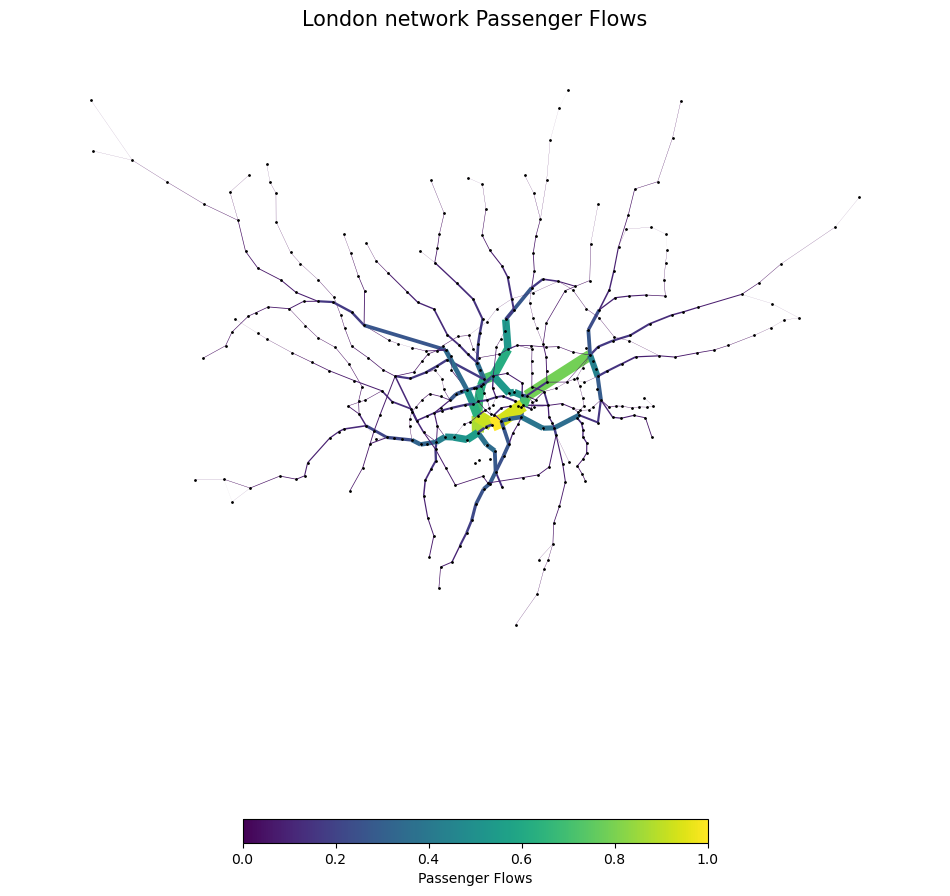

In [12]:
#plot our calcuated flows
flows_values = flows.values()
flow_color=[(i[2]['flows']/max(flows_values)) for i in G.edges(data=True)]
flow_width=[(i[2]['flows']/max(flows_values)*10) for i in G.edges(data=True)]


# Plot graph
fig, ax = plt.subplots(figsize=(12,12))

#pos=nx.spring_layout(X)
edg=nx.draw_networkx_edges(G, pos,edge_color=flow_color, width=flow_width)

nx.draw_networkx_nodes(G,
        pos = pos,
        node_color= 'black',
        node_size= 1)

plt.colorbar(edg,label="Passenger Flows",orientation="horizontal", shrink=0.5)
plt.axis("off")
plt.title("London network Passenger Flows",fontsize=15)
plt.show()

### 2 Calculate 3 centrality measures

#### 2.1 degree centrality on nodes

In [13]:
deg_london =nx.degree_centrality(G)
nx.set_node_attributes(G,dict(deg_london),'degree')
# To dataframe using the nodes as the index
degree_df = pd.DataFrame()
# df['station_name'] = pd.Series(nx.get_node_attributes(G, 'station_name'))
degree_df['degree'] = pd.Series(nx.get_node_attributes(G, 'degree'))
degree_df.reset_index(inplace = True)
degree_df_1 = degree_df.rename(columns = {'index':'Stations'},inplace = True)
degree_sorted = degree_df.sort_values(["degree","Stations"], ascending=False)
degree_top10 = degree_sorted[0:11]
degree_top10

,Stations,degree
49,Stratford,0.0225
31,Bank and Monument,0.0200
9,King's Cross St. Pancras,0.0175
35,Baker Street,0.0175
52,West Ham,0.0150
103,Waterloo,0.0150
6,Oxford Circus,0.0150
34,Liverpool Street,0.0150
5,Green Park,0.0150
156,Earl's Court,0.0150


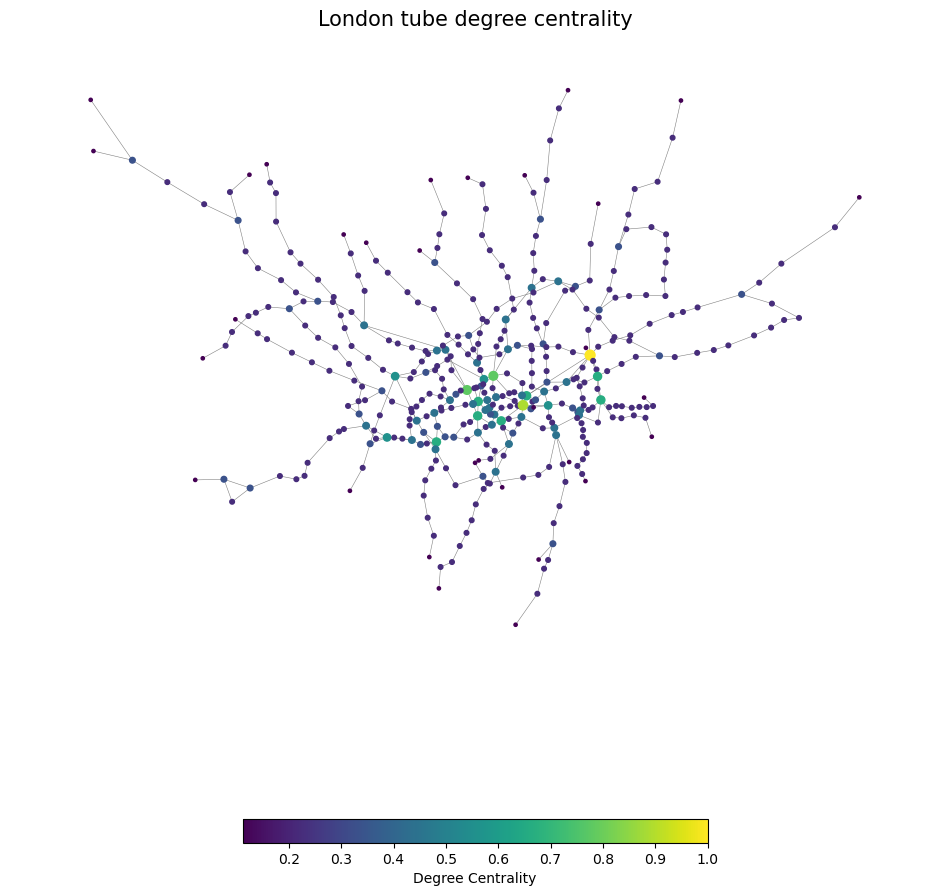

In [14]:
# set colour and size of nodes according to degree centrality values
degree_values=[(i[1]['degree']) for i in G.nodes(data=True)]
deg_color=[(i[1]['degree']/(max(degree_values))) for i in G.nodes(data=True)]
deg_size=[(i[1]['degree']/(max(degree_values)))*50 for i in G.nodes(data=True)]
# Plot graph
pos=pos
fig, ax = plt.subplots(figsize=(12,12))
nx.draw_networkx_edges(G, pos,edge_color='gray', 
        width=0.4)
nod=nx.draw_networkx_nodes(G,
        pos = pos,
        node_color= deg_color,
        node_size= deg_size)
plt.colorbar(nod,label="Degree Centrality",orientation="horizontal", shrink=0.5)
plt.axis("off")
plt.title("London tube degree centrality",fontsize=15)
plt.show()

#### 2.2 Topological betweenness centrality on nodes

In [41]:
#compute the betweenness centrality for the network, without using weights:
bet_london_t=nx.betweenness_centrality(G, normalized= True)
# add these values to the nodes attributes:
nx.set_node_attributes(G,bet_london_t,'betweenness_t')
# To dataframe using the nodes as the index
T_betweenness_df = pd.DataFrame(index=G.nodes())
# df['station_name'] = pd.Series(nx.get_node_attributes(G, 'station_name'))
T_betweenness_df['betweenness_t'] = pd.Series(nx.get_node_attributes(G, 'betweenness_t'))
T_betweenness_df_sorted = T_betweenness_df.sort_values(["betweenness_t"], ascending=False)
T_betweenness_top10 = T_betweenness_df_sorted[0:10]

T_betweenness_top10.reset_index(inplace = True)
T_betweenness_top10.rename(columns = {'index':'Stations'},inplace = True)
T_betweenness_top10


C:\Users\zhaol\AppData\Local\Temp\ipykernel_7908\2299026789.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  T_betweenness_top10.rename(columns = {'index':'Stations'},inplace = True)


,Stations,betweenness_t
0,Stratford,0.297846
1,Bank and Monument,0.290489
2,Liverpool Street,0.270807
3,King's Cross St. Pancras,0.255307
4,Waterloo,0.243921
5,Green Park,0.215835
6,Euston,0.208324
7,Westminster,0.203335
8,Baker Street,0.191568
9,Finchley Road,0.165085


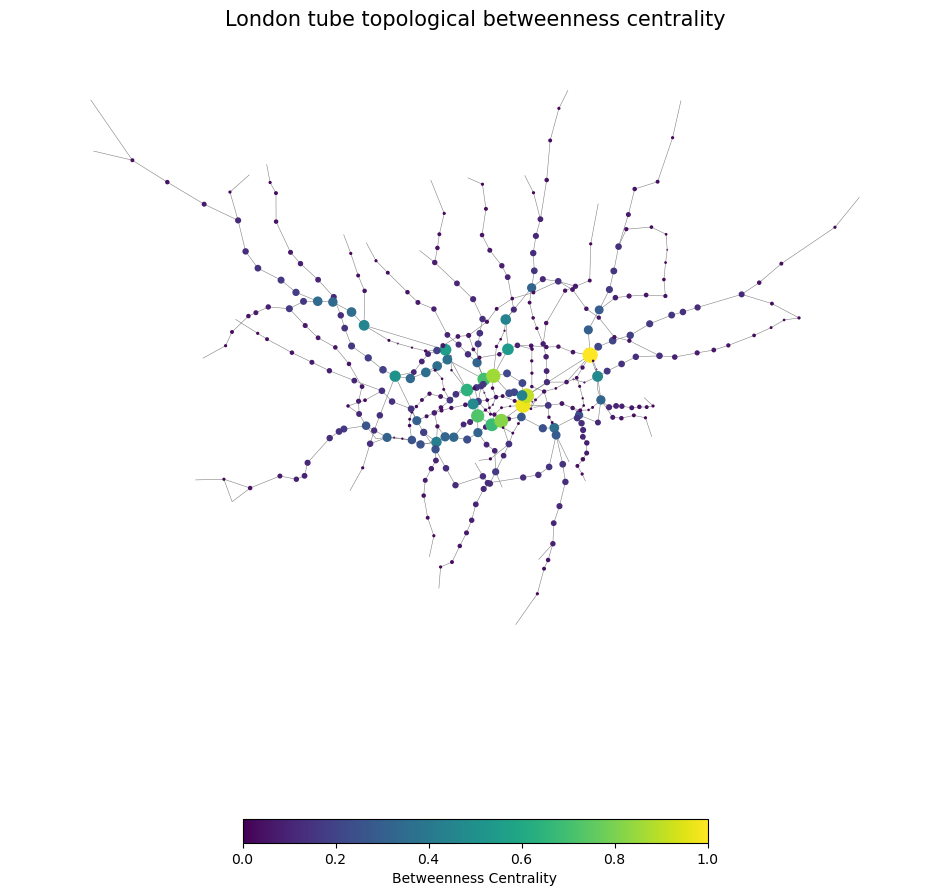

In [42]:
#set colour and size of nodes according to betweenness values
betweenness_t_values=[(i[1]['betweenness_t']) for i in G.nodes(data=True)]
bet_t_color=[(i[1]['betweenness_t']/max(betweenness_t_values)) for i in G.nodes(data=True)]
bet_t_size=[(i[1]['betweenness_t']/max(betweenness_t_values))*100 for i in G.nodes(data=True)]
# Plot graph
fig, ax = plt.subplots(figsize=(12,12))
nx.draw_networkx_edges(G, pos,edge_color='gray', width=0.4)
nod=nx.draw_networkx_nodes(G, pos = pos, node_color= bet_t_color, node_size= bet_t_size)
plt.colorbar(nod,label="Betweenness Centrality",orientation="horizontal", shrink=0.5)
plt.axis("off")
plt.title("London tube topological betweenness centrality",fontsize=15)
plt.show()

#### 2.3 Topological closeness centrality

In [44]:
clos_t=nx.closeness_centrality(G)
# We can add these values to the nodes attributes:
nx.set_node_attributes(G,clos_t,'closeness_t')
# To dataframe using the nodes as the index
T_closeness_df = pd.DataFrame(index=G.nodes())
# df['station_name'] = pd.Series(nx.get_node_attributes(G, 'station_name'))
T_closeness_df['closeness_t'] = pd.Series(nx.get_node_attributes(G, 'closeness_t'))
T_closeness_df_sorted = T_closeness_df.sort_values(["closeness_t"], ascending=False)
T_closeness_top10 = T_closeness_df_sorted[0:10]
T_closeness_top10
T_closeness_top10.reset_index(inplace = True)
T_closeness_top10.rename(columns = {'index':'Stations'},inplace = True)
T_closeness_top10

C:\Users\zhaol\AppData\Local\Temp\ipykernel_7908\1744056132.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  T_closeness_top10.rename(columns = {'index':'Stations'},inplace = True)


,Stations,closeness_t
0,Green Park,0.114778
1,Bank and Monument,0.113572
2,King's Cross St. Pancras,0.113443
3,Westminster,0.112549
4,Waterloo,0.112265
5,Oxford Circus,0.111204
6,Bond Street,0.110988
7,Angel,0.110742
8,Farringdon,0.110742
9,Moorgate,0.110314


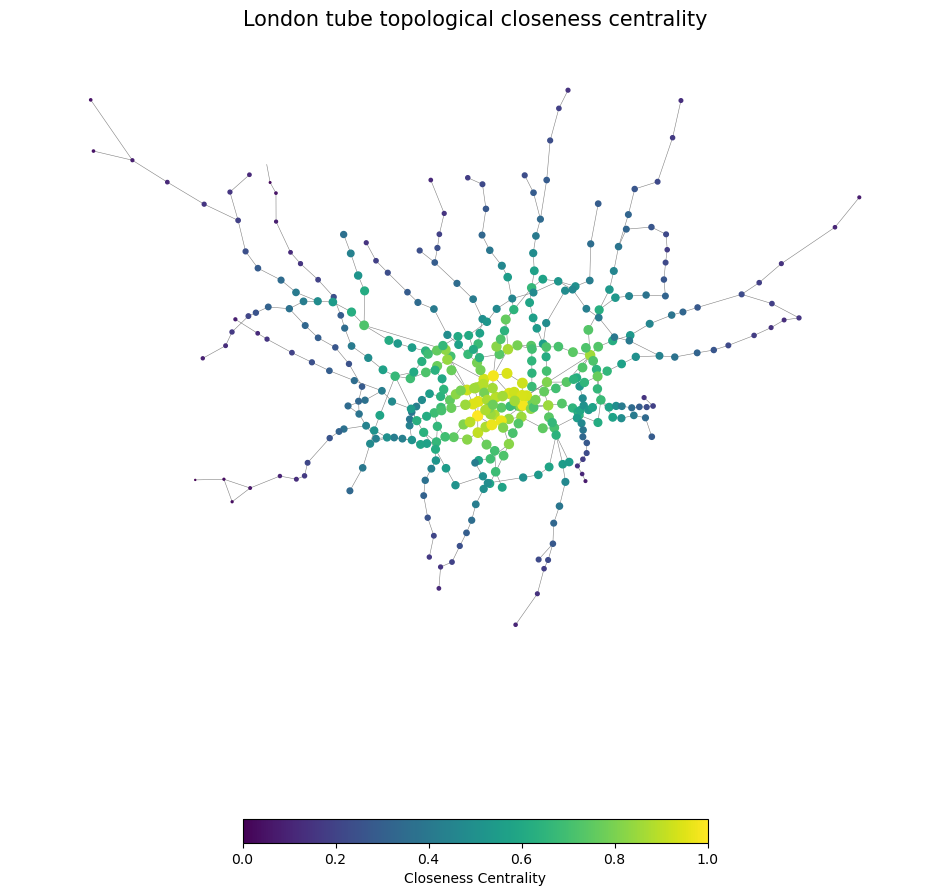

In [18]:
#set color and width of nodes according to the closeness values
clos_t_val=[(i[1]['closeness_t']) for i in G.nodes(data=True)]
closs_t_color=[(i[1]['closeness_t']-min(clos_t_val))/(max(clos_t_val)-min(clos_t_val)) for i in G.nodes(data=True)]
closs_t_size=[((i[1]['closeness_t']-min(clos_t_val))/(max(clos_t_val)-min(clos_t_val))*50) for i in G.nodes(data=True)]
# Plot graph
fig, ax = plt.subplots(figsize=(12,12))
nx.draw_networkx_edges(G, pos,edge_color='gray', 
        width=0.4)
nod=nx.draw_networkx_nodes(G,
        pos = pos,
        node_color= closs_t_color,
        node_size= closs_t_size)
plt.colorbar(nod,label="Closeness Centrality",orientation="horizontal", shrink=0.5)
plt.axis("off")
plt.title("London tube topological closeness centrality",fontsize=15)
plt.show()

#### 2.4 topological eigenvector centrality

In [77]:
t_eigen = nx.eigenvector_centrality_numpy(G)
nx.set_node_attributes(G,t_eigen,'t_eigen')
# To dataframe using the nodes as the index
t_eigen_df = pd.DataFrame(index=G.nodes())
t_eigen_df['t_eigen'] = pd.Series(nx.get_node_attributes(G, 't_eigen'))
t_eigen_df_sorted = t_eigen_df.sort_values(["t_eigen"], ascending=False)
t_eigen_top10 = t_eigen_df_sorted[0:10]
t_eigen_top10
t_eigen_top10.reset_index(inplace = True)
t_eigen_top10.rename(columns = {'index':'Stations'},inplace = True)
t_eigen_top10

C:\Users\zhaol\AppData\Local\Temp\ipykernel_7908\3154065763.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t_eigen_top10.rename(columns = {'index':'Stations'},inplace = True)


,Stations,t_eigen
0,Bank and Monument,0.383725
1,Liverpool Street,0.329191
2,Stratford,0.269574
3,Waterloo,0.249708
4,Moorgate,0.215343
5,Green Park,0.197023
6,Oxford Circus,0.183441
7,Tower Hill,0.171839
8,Westminster,0.168368
9,Shadwell,0.159233


### 2.1 Task 1	(Non-sequential removal)

In [19]:
## Original situation
# To comput the original size ( number of node) of each component
Subg = [G.subgraph(c).copy() for c in nx.connected_components(G)]
print("size of components: ",[len(subgraph.nodes) for subgraph in Subg])
# Get the list of components:
components = nx.connected_components(G)
# Use the max() command to find the largest one:
largest_component = max(components, key=len)
# Create a "subgraph" of the largest component
Largest_subgraph = G.subgraph(largest_component)
#compute the diameter of this new graph 
diameter = nx.diameter(Largest_subgraph)
print("Diameter is : ",diameter)
#clustering coefficients
clustering = nx.clustering(G)
clustering_list = list(clustering.values())
clustering_list_mean = np.mean(clustering_list)
print(clustering_list_mean)
print("Number of the components:",nx.number_connected_components(G))

size of components:  [401]
Diameter is :  36
0.030382377389858682
Number of the components: 1


In [20]:
## non-sequential node removal based on degree centrality
G1=G.copy() #graph for task 1
degree_top10_list = degree_top10.iloc[:,0].tolist()
degree_top10_list

largest_component = []
diameter = []
clustering_list_mean = []
num_com = []
for i in range(len(degree_top10_list)):
    G1.remove_node(degree_top10_list[i])#important!!!
    print("The removed station is : ",degree_top10_list[i])
    print("Whether the whole original network is connected: ", nx.is_connected(G1))
#     print("Number of the components:",nx.number_connected_components(G1))
    num_com.append(nx.number_connected_components(G1))
    # Comput the size ( number of node) of each component
    Subg = [G1.subgraph(c).copy() for c in nx.connected_components(G1)]
    print("Size of each component:",[len(subgraph.nodes) for subgraph in Subg])
    components = nx.connected_components(G1)# Get the list of components
    largest_component_i = max(components, key=len)# Use the max() command to find the largest one
    largest_component.append(len(largest_component_i))
    Largest_subgraph = G1.subgraph(largest_component_i)# Create a "subgraph" of the largest component
    diameter.append(nx.diameter(Largest_subgraph))#compute the diameter of this new graph 
    clustering = nx.clustering(G1)
    clustering_list = list(clustering.values())
    clustering_list_mean.append(np.mean(clustering_list))
print("The largest component is : ",largest_component)
print("The diameter of the largest component is :",diameter)
print("The average clustering coefficient is :",clustering_list_mean) #mean clustering coefficients of rest network


non_seq_dc = pd.DataFrame({'remove_stations':degree_top10_list,'largest component':largest_component,
                           'diameter':diameter,'average clustering coefficient':clustering_list_mean,'component_num':num_com})
non_seq_dc.loc[-1] = ['None (Original network)',401,36, 0.030382,1]
non_seq_dc.index = non_seq_dc.index + 1
non_seq_dc.sort_index(inplace=True) 
non_seq_dc

The removed station is :  Stratford
Whether the whole original network is connected:  False
Size of each component: [379, 1, 20]
The removed station is :  Bank and Monument
Whether the whole original network is connected:  False
Size of each component: [378, 1, 20]
The removed station is :  King's Cross St. Pancras
Whether the whole original network is connected:  False
Size of each component: [377, 1, 20]
The removed station is :  Baker Street
Whether the whole original network is connected:  False
Size of each component: [374, 2, 1, 20]
The removed station is :  West Ham
Whether the whole original network is connected:  False
Size of each component: [371, 2, 2, 1, 20]
The removed station is :  Waterloo
Whether the whole original network is connected:  False
Size of each component: [370, 2, 2, 1, 20]
The removed station is :  Oxford Circus
Whether the whole original network is connected:  False
Size of each component: [368, 2, 2, 1, 20, 1]
The removed station is :  Liverpool Street
Wh

,remove_stations,largest component,diameter,average clustering coefficient,component_num
0,None (Original network),401,36,0.030382,1
1,Stratford,379,49,0.030625,3
2,Bank and Monument,378,49,0.030027,3
3,King's Cross St. Pancras,377,49,0.030270,3
4,Baker Street,374,49,0.027288,4
5,West Ham,371,53,0.024411,5
6,Waterloo,370,53,0.023376,5
7,Oxford Circus,368,53,0.021912,6
8,Liverpool Street,362,53,0.021968,7
9,Green Park,361,53,0.023724,7


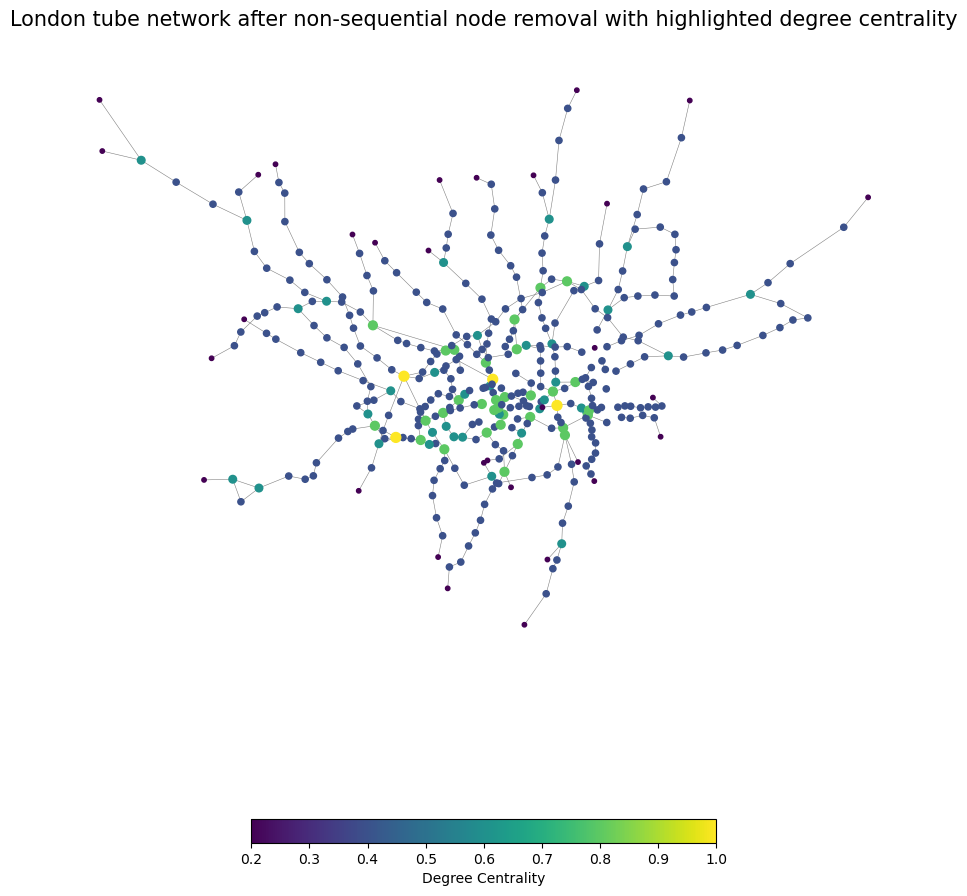

In [21]:
## draw a network graph after 11 most important stations based on degree centrality
# non-sequential removal

degree_values=[(i[1]['degree']) for i in G1.nodes(data=True)]
deg_color=[(i[1]['degree']/(max(degree_values))) for i in G1.nodes(data=True)]
deg_size=[(i[1]['degree']/(max(degree_values)))*50 for i in G1.nodes(data=True)]
fig, ax = plt.subplots(figsize=(12,12))
nx.draw_networkx_edges(G1, pos,edge_color='gray', 
        width=0.4)
nod=nx.draw_networkx_nodes(G1,
        pos = pos,
        node_color= deg_color,
        node_size= deg_size)

plt.colorbar(nod,label="Degree Centrality",orientation="horizontal", shrink=0.5)
plt.axis("off")
plt.title("London tube network after non-sequential node removal with highlighted degree centrality",fontsize=15)
#save the plot
# plt.savefig('non_seq_dc_network.png', dpi=300, bbox_inches='tight')

plt.show()

In [22]:
#For topological betweenness centrality top 10 stations
G1_tb=G.copy()

T_betweenness_top10_list = T_betweenness_top10.iloc[:,0].tolist()
T_betweenness_top10_list
largest_component_tb = []
diameter_tb = []
clustering_list_mean_tb = []
num_com = []
for i in range(len(T_betweenness_top10_list)):
    G1_tb.remove_node(T_betweenness_top10_list[i])#important!!!
    print("The removed station is : ",T_betweenness_top10_list[i])
    print("Whether the whole original network is connected: ", nx.is_connected(G1_tb))
#     print("Number of the components:",nx.number_connected_components(G1_tb))
    num_com.append(nx.number_connected_components(G1_tb))
    # Comput the size ( number of node) of each component
    Subg_tb = [G1_tb.subgraph(c).copy() for c in nx.connected_components(G1_tb)]
    print("Size of each component:",[len(subgraph.nodes) for subgraph in Subg_tb])
    components = nx.connected_components(G1_tb)# Get the list of components
    largest_component_tbi = max(components, key=len)# Use the max() command to find the largest one
    largest_component_tb.append(len(largest_component_tbi))
    Largest_subgraph = G1_tb.subgraph(largest_component_tbi)# Create a "subgraph" of the largest component
    diameter_tb.append(nx.diameter(Largest_subgraph))#compute the diameter of this new graph 
    clustering = nx.clustering(G1_tb)
    clustering_list = list(clustering.values())
    clustering_list_mean_tb.append(np.mean(clustering_list))

print("The largest component is : ",largest_component_tb)
print("The diameter of the largest component is :",diameter_tb)
print("The average clustering coefficient is :",clustering_list_mean_tb) #mean clustering coefficients of rest network

non_seq_tb = pd.DataFrame({'remove_stations':T_betweenness_top10_list,'largest component':largest_component_tb,
                           'diameter':diameter_tb,'average clustering coefficient':clustering_list_mean_tb,'component_num':num_com})
non_seq_tb.loc[-1] = ['None (Original network)',401,36, 0.030382,1]
non_seq_tb.index = non_seq_tb.index + 1
non_seq_tb.sort_index(inplace=True) 
non_seq_tb

The removed station is :  Stratford
Whether the whole original network is connected:  False
Size of each component: [379, 1, 20]
The removed station is :  Bank and Monument
Whether the whole original network is connected:  False
Size of each component: [378, 1, 20]
The removed station is :  Liverpool Street
Whether the whole original network is connected:  False
Size of each component: [377, 1, 20]
The removed station is :  King's Cross St. Pancras
Whether the whole original network is connected:  False
Size of each component: [371, 5, 1, 20]
The removed station is :  Waterloo
Whether the whole original network is connected:  False
Size of each component: [370, 5, 1, 20]
The removed station is :  Green Park
Whether the whole original network is connected:  False
Size of each component: [369, 5, 1, 20]
The removed station is :  Euston
Whether the whole original network is connected:  False
Size of each component: [346, 5, 1, 22, 20]
The removed station is :  Westminster
Whether the whol

,remove_stations,largest component,diameter,average clustering coefficient,component_num
0,None (Original network),401,36,0.030382,1
1,Stratford,379,49,0.030625,3
2,Bank and Monument,378,49,0.030027,3
3,Liverpool Street,377,49,0.030103,3
4,King's Cross St. Pancras,371,49,0.030347,4
5,Waterloo,370,49,0.029329,4
6,Green Park,369,49,0.028306,4
7,Euston,346,49,0.024994,5
8,Westminster,345,49,0.025058,5
9,Baker Street,342,49,0.021599,6


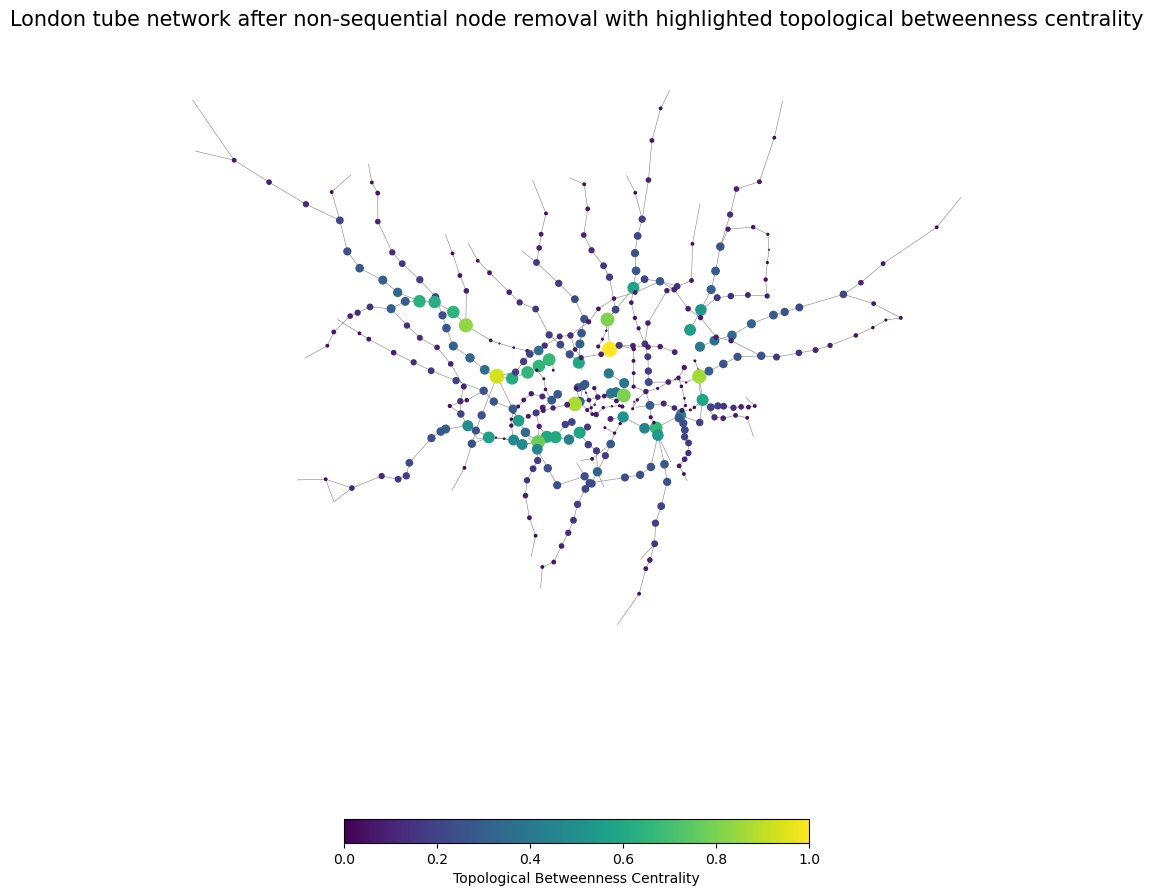

In [23]:
## draw a network graph after 11 most important stations based on topological betweenness centrality
# non-sequential removal

betweenness_t_values=[(i[1]['betweenness_t']) for i in G1_tb.nodes(data=True)]
bet_t_color=[(i[1]['betweenness_t']/max(betweenness_t_values)) for i in G1_tb.nodes(data=True)]
bet_t_size=[(i[1]['betweenness_t']/max(betweenness_t_values))*100 for i in G1_tb.nodes(data=True)]
fig, ax = plt.subplots(figsize=(12,12))
nx.draw_networkx_edges(G1_tb, pos,edge_color='gray', 
        width=0.4)
nod=nx.draw_networkx_nodes(G1_tb,
        pos = pos,
        node_color= bet_t_color,
        node_size= bet_t_size)
plt.colorbar(nod,label="Topological Betweenness Centrality",orientation="horizontal", shrink=0.5)
plt.axis("off")
plt.title("London tube network after non-sequential node removal with highlighted topological betweenness centrality",fontsize=15)
#save the plot
plt.savefig('non_seq_tb_network.png', dpi=300, bbox_inches='tight')

plt.show()

In [24]:
#For topological closeness centrality top 10 stations
G1_tc=G.copy()

T_closeness_top10_list = T_closeness_top10.iloc[:,0].tolist()
T_closeness_top10_list
largest_component_tc = []
diameter_tc = []
clustering_list_mean_tc = []
num_com = []
for i in range(len(T_closeness_top10_list)):
    G1_tc.remove_node(T_closeness_top10_list[i])#important!!!
    print("The removed station is : ",T_closeness_top10_list[i])
    print("Whether the whole original network is connected: ", nx.is_connected(G1_tc))
#     print("Number of the components:",nx.number_connected_components(G1_tc))
    num_com.append(nx.number_connected_components(G1_tc))
    # Comput the size ( number of node) of each component
    Subg_tc = [G1_tc.subgraph(c).copy() for c in nx.connected_components(G1_tc)]
    print("Size of each component:",[len(subgraph.nodes) for subgraph in Subg_tc])
    components = nx.connected_components(G1_tc)# Get the list of components
    largest_component_tci = max(components, key=len)# Use the max() command to find the largest one
    largest_component_tc.append(len(largest_component_tci))
    Largest_subgraph = G1_tc.subgraph(largest_component_tci)# Create a "subgraph" of the largest component
    diameter_tc.append(nx.diameter(Largest_subgraph))#compute the diameter of this new graph 
    clustering = nx.clustering(G1_tc)
    clustering_list = list(clustering.values())
    clustering_list_mean_tc.append(np.mean(clustering_list))

print("The largest component is : ",largest_component_tc)
print("The diameter of the largest component is :",diameter_tc)
print("The average clustering coefficient is :",clustering_list_mean_tc) #mean clustering coefficients of rest network

non_seq_tc = pd.DataFrame({'remove_stations':T_closeness_top10_list,'largest component':largest_component_tc,
                           'diameter':diameter_tc,'average clustering coefficient':clustering_list_mean_tc,'component_num':num_com})
non_seq_tc.loc[-1] = ['None (Original network)',401,36, 0.030382,1]
non_seq_tc.index = non_seq_tc.index + 1
non_seq_tc.sort_index(inplace=True) 
non_seq_tc

The removed station is :  Green Park
Whether the whole original network is connected:  True
Size of each component: [400]
The removed station is :  Bank and Monument
Whether the whole original network is connected:  True
Size of each component: [399]
The removed station is :  King's Cross St. Pancras
Whether the whole original network is connected:  True
Size of each component: [398]
The removed station is :  Westminster
Whether the whole original network is connected:  True
Size of each component: [397]
The removed station is :  Waterloo
Whether the whole original network is connected:  True
Size of each component: [396]
The removed station is :  Oxford Circus
Whether the whole original network is connected:  True
Size of each component: [395]
The removed station is :  Bond Street
Whether the whole original network is connected:  True
Size of each component: [394]
The removed station is :  Angel
Whether the whole original network is connected:  True
Size of each component: [393]
The r

,remove_stations,largest component,diameter,average clustering coefficient,component_num
0,None (Original network),401,36,0.030382,1
1,Green Park,400,36,0.029792,1
2,Bank and Monument,399,38,0.029276,1
3,King's Cross St. Pancras,398,42,0.029517,1
4,Westminster,397,42,0.028080,1
5,Waterloo,396,42,0.028151,1
6,Oxford Circus,395,45,0.029910,1
7,Bond Street,394,45,0.030034,1
8,Angel,393,45,0.030110,1
9,Farringdon,392,45,0.030187,1


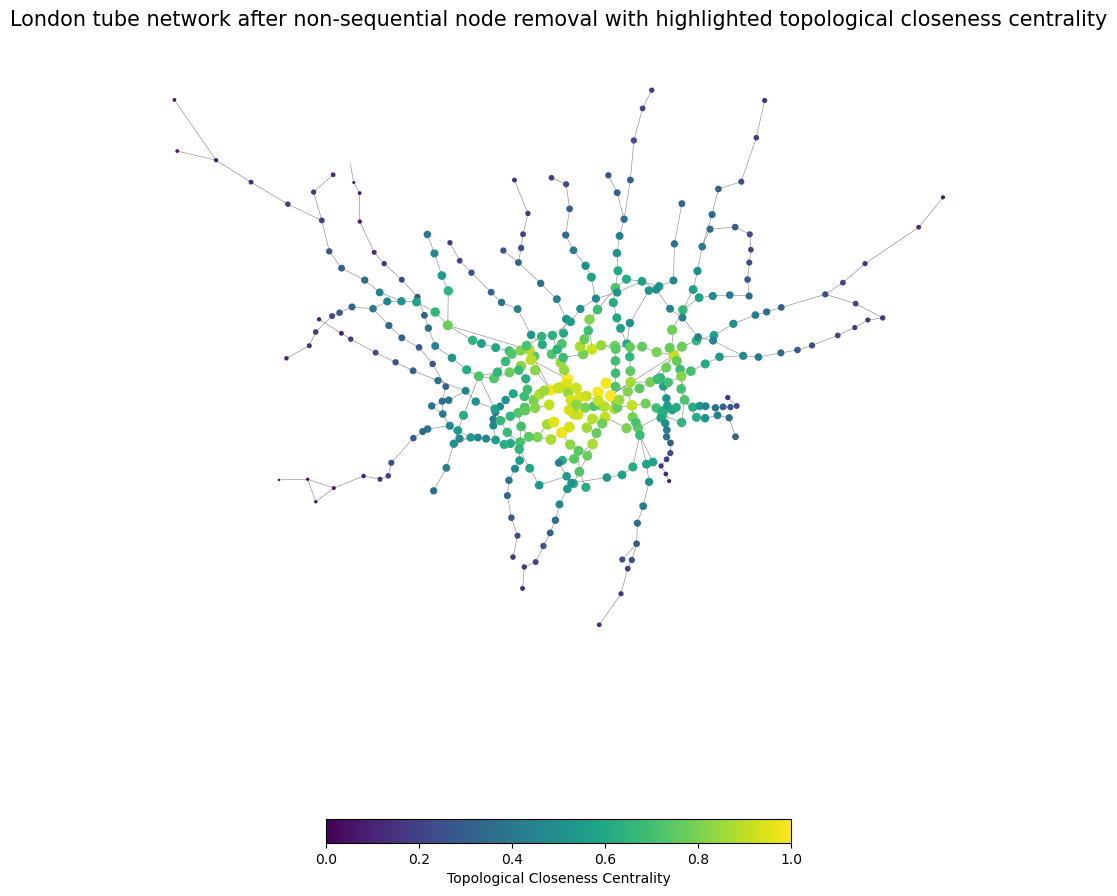

In [25]:
## draw a network graph after 1 most important stations based on topological closeness centrality
# non-sequential removal

clos_t_val=[(i[1]['closeness_t']) for i in G1_tc.nodes(data=True)]
closs_t_color=[(i[1]['closeness_t']-min(clos_t_val))/(max(clos_t_val)-min(clos_t_val)) for i in G1_tc.nodes(data=True)]
closs_t_size=[((i[1]['closeness_t']-min(clos_t_val))/(max(clos_t_val)-min(clos_t_val))*50) for i in G1_tc.nodes(data=True)]
fig, ax = plt.subplots(figsize=(12,12))
nx.draw_networkx_edges(G1_tc, pos,edge_color='gray', 
        width=0.4)
nod=nx.draw_networkx_nodes(G1_tc,
        pos = pos,
        node_color= closs_t_color,
        node_size= closs_t_size)
plt.colorbar(nod,label="Topological Closeness Centrality",orientation="horizontal", shrink=0.5)
plt.axis("off")
plt.title("London tube network after non-sequential node removal with highlighted topological closeness centrality",fontsize=15)
#save the plot
plt.savefig('non_seq_tc_network.png', dpi=300, bbox_inches='tight')

plt.show()

In [79]:
#For topological eigenvector centrality top 10 stations
G1_te=G.copy()
t_eigen_top10_list = t_eigen_top10.iloc[:,0].tolist()
t_eigen_top10_list
largest_component_te = []
diameter_te = []
clustering_list_mean_te = []
num_com_te = []
for i in range(len(t_eigen_top10_list)):
    G1_te.remove_node(t_eigen_top10_list[i])#important!!!
    print("The removed station is : ",t_eigen_top10_list[i])
    print("Whether the whole original network is connected: ", nx.is_connected(G1_te))
    num_com_te.append(nx.number_connected_components(G1_te))
    # Comput the size ( number of node) of each component
#     Subg_te = [G1_te.subgraph(c).copy() for c in nx.connected_components(G1_te)]
#     print("Size of each component:",[len(subgraph.nodes) for subgraph in Subg_te])
    components = nx.connected_components(G1_te)# Get the list of components
    largest_component_tei = max(components, key=len)# Use the max() command to find the largest one
    largest_component_te.append(len(largest_component_tei))
    Largest_subgraph = G1_te.subgraph(largest_component_tei)# Create a "subgraph" of the largest component
    diameter_te.append(nx.diameter(Largest_subgraph))#compute the diameter of this new graph 
    clustering = nx.clustering(G1_te)
    clustering_list = list(clustering.values())
    clustering_list_mean_te.append(np.mean(clustering_list))

print("The largest component is : ",largest_component_te)
print("The diameter of the largest component is :",diameter_te)
print("The average clustering coefficient is :",clustering_list_mean_te) #mean clustering coefficients of rest network

non_seq_te = pd.DataFrame({'remove_stations':t_eigen_top10_list,'largest component':largest_component_te,
                           'diameter':diameter_te,'average clustering coefficient':clustering_list_mean_te,'component_num':num_com_te})
non_seq_te.loc[-1] = ['None (Original network)',401,36, 0.030382,1]
non_seq_te.index = non_seq_te.index + 1
non_seq_te.sort_index(inplace=True) 
print(non_seq_te)

The removed station is :  Bank and Monument
Whether the whole original network is connected:  True
The removed station is :  Liverpool Street
Whether the whole original network is connected:  True
The removed station is :  Stratford
Whether the whole original network is connected:  False
The removed station is :  Waterloo
Whether the whole original network is connected:  False
The removed station is :  Moorgate
Whether the whole original network is connected:  False
The removed station is :  Green Park
Whether the whole original network is connected:  False
The removed station is :  Oxford Circus
Whether the whole original network is connected:  False
The removed station is :  Tower Hill
Whether the whole original network is connected:  False
The removed station is :  Westminster
Whether the whole original network is connected:  False
The removed station is :  Shadwell
Whether the whole original network is connected:  False
The largest component is :  [400, 399, 377, 376, 375, 374, 373

,remove_stations,largest component,diameter,average clustering coefficient,component_num
0,None (Original network),401,36,0.030382,1
1,Bank and Monument,400,38,0.029869,1
2,Liverpool Street,399,40,0.029944,1
3,Stratford,377,49,0.030103,3
4,Waterloo,376,49,0.029087,3
5,Moorgate,375,49,0.029161,3
6,Green Park,374,49,0.028137,3
7,Oxford Circus,373,49,0.029901,3
8,Tower Hill,371,49,0.029977,4
9,Westminster,370,49,0.030053,4


### 2.2 Task 2	(Sequential removal)

In [26]:
def deg_removal_stations(G):
    remove_list = []
    Degree_10 = []
    for i in range(10):
        deg_london = nx.degree_centrality(G)
        nx.set_node_attributes(G, dict(deg_london), 'degree')
        degree_df2_1 = pd.DataFrame()
        degree_df2_1['degree'] = pd.Series(nx.get_node_attributes(G, 'degree'))
        degree_df2_1.reset_index(inplace=True)
        degree_df2_1.rename(columns={'index': 'Stations'}, inplace=True)
        degree_sorted2_1 = degree_df2_1.sort_values(["degree", "Stations"], ascending=False)
        remove_list.append(degree_sorted2_1.iloc[0, 0])
        G.remove_node(degree_sorted2_1.iloc[0, 0])
        Degree_10.append(degree_sorted2_1.iloc[0, 1])
    print("Degree_10:", Degree_10)
    return remove_list

def bet_removal_stations(G):
    remove_list = []
    Degree_10 = []
    for i in range(10):
        deg_london = nx.betweenness_centrality(G)
        nx.set_node_attributes(G, dict(deg_london), 'betweenness_t')
        degree_df2_1 = pd.DataFrame()
        degree_df2_1['betweenness_t'] = pd.Series(nx.get_node_attributes(G, 'betweenness_t'))
        degree_df2_1.reset_index(inplace=True)
        degree_df2_1.rename(columns={'index': 'Stations'}, inplace=True)
        degree_sorted2_1 = degree_df2_1.sort_values(["betweenness_t", "Stations"], ascending=False)
        remove_list.append(degree_sorted2_1.iloc[0, 0])
        G.remove_node(degree_sorted2_1.iloc[0, 0])
        Degree_10.append(degree_sorted2_1.iloc[0, 1])
    print("Degree_10:", Degree_10)
    return remove_list

def clo_removal_stations(G):
    remove_list = []
    Degree_10 = []
    for i in range(10):
        deg_london = nx.closeness_centrality(G)
        nx.set_node_attributes(G, dict(deg_london), 'closeness_t')
        degree_df2_1 = pd.DataFrame()
        degree_df2_1['closeness_t'] = pd.Series(nx.get_node_attributes(G, 'closeness_t'))
        degree_df2_1.reset_index(inplace=True)
        degree_df2_1.rename(columns={'index': 'Stations'}, inplace=True)
        degree_sorted2_1 = degree_df2_1.sort_values(["closeness_t", "Stations"], ascending=False)
        remove_list.append(degree_sorted2_1.iloc[0, 0])
        G.remove_node(degree_sorted2_1.iloc[0, 0])
        Degree_10.append(degree_sorted2_1.iloc[0, 1])
    print("Degree_10:", Degree_10)
    return remove_list

In [27]:
def calculation(G,stationlist):
#     com_num = []
    L_components = []
    diameter = []
    mean_cluster = []
    num_com = []
    for i in range(len(stationlist)):
        G.remove_node(stationlist[i])
        print("The removed station is : ",stationlist[i])
        num_com.append(nx.number_connected_components(G))
        components = nx.connected_components(G)# Get the list of components
        largest_component = max(components, key=len)# Use the max() command to find the largest one
        Largest_subgraph = G.subgraph(largest_component)# Create a "subgraph" of the largest component
        L_components.append(len(largest_component))
        diameter.append(nx.diameter(Largest_subgraph))#compute the diameter of this new graph 
        clustering = nx.clustering(G)
        clustering_list = list(clustering.values())
        clustering_list_mean = np.mean(clustering_list)
        mean_cluster.append(clustering_list_mean)
    data_dict = {
        'diameter': diameter,
        'largest component': L_components,
        'average clustering coefficient': mean_cluster,
        'component_num':num_com
    }
    seq = pd.DataFrame(data_dict)
    return seq

In [28]:
G2_degree_st = G.copy()#graph for task 2 degree centrality
G2_degree_ca = G.copy()
deg_stationlist = deg_removal_stations(G2_degree_st)# get the removal list of the stations
seq_dc = calculation(G2_degree_ca,deg_stationlist)
seq_dc.insert(0, "remove_stations", deg_stationlist)
seq_dc.loc[-1] = ['None (Original network)',36,401, 0.030382,1]
seq_dc.index = seq_dc.index + 1
seq_dc.sort_index(inplace=True) 
seq_dc

Degree_10: [0.0225, 0.020050125313283207, 0.017587939698492462, 0.017632241813602016, 0.015151515151515152, 0.01518987341772152, 0.015228426395939085, 0.012722646310432571, 0.012755102040816325, 0.012787723785166242]
The removed station is :  Stratford
The removed station is :  Bank and Monument
The removed station is :  King's Cross St. Pancras
The removed station is :  Baker Street
The removed station is :  Oxford Circus
The removed station is :  Earl's Court
The removed station is :  Canning Town
The removed station is :  Willesden Junction
The removed station is :  Waterloo
The removed station is :  Turnham Green


,remove_stations,diameter,largest component,average clustering coefficient,component_num
0,None (Original network),36,401,0.030382,1
1,Stratford,49,379,0.030625,3
2,Bank and Monument,49,378,0.030027,3
3,King's Cross St. Pancras,49,377,0.030270,3
4,Baker Street,49,374,0.027288,4
5,Oxford Circus,49,372,0.025842,5
6,Earl's Court,50,371,0.019072,5
7,Canning Town,51,357,0.016159,7
8,Willesden Junction,56,343,0.016200,8
9,Waterloo,58,342,0.015136,8


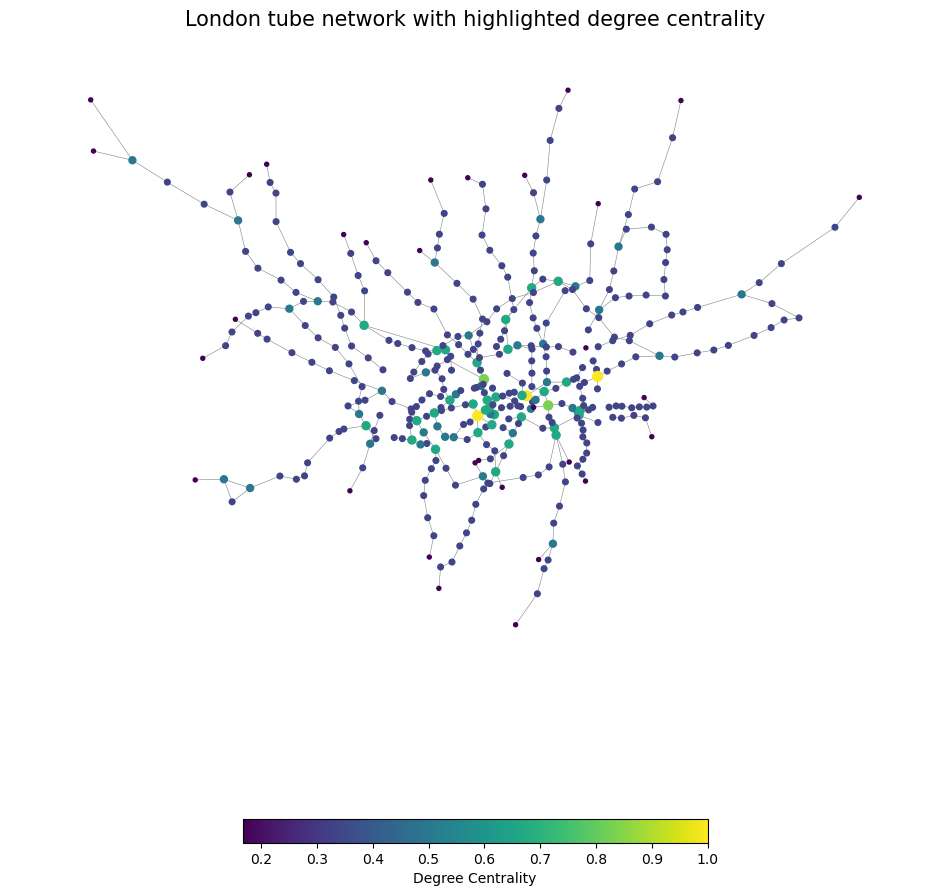

In [29]:
## draw a network graph after 11 most important stations based on degree centrality
# sequential removal

degree_values=[(i[1]['degree']) for i in G2_degree_ca.nodes(data=True)]
deg_color=[(i[1]['degree']/(max(degree_values))) for i in G2_degree_ca.nodes(data=True)]
deg_size=[(i[1]['degree']/(max(degree_values)))*50 for i in G2_degree_ca.nodes(data=True)]
fig, ax = plt.subplots(figsize=(12,12))
nx.draw_networkx_edges(G2_degree_ca, pos,edge_color='gray', 
        width=0.4)
nod=nx.draw_networkx_nodes(G2_degree_ca,
        pos = pos,
        node_color= deg_color,
        node_size= deg_size)
plt.colorbar(nod,label="Degree Centrality",orientation="horizontal", shrink=0.5)
plt.axis("off")
plt.title("London tube network with highlighted degree centrality",fontsize=15)
#save the plot
plt.savefig('seq_dc_network.png', dpi=300, bbox_inches='tight')

plt.show()

In [30]:
G2_t_bet_st=G.copy() #graph for topological betweenness centrality
G2_t_bet_ca=G.copy()
bet_stationlist = bet_removal_stations(G2_t_bet_st)# get the removal list of the stations
seq_tb = calculation(G2_t_bet_ca,bet_stationlist)
seq_tb.insert(0, "remove_stations", bet_stationlist)
seq_tb.loc[-1] = ['None (Original network)',36,401, 0.030382,1]
seq_tb.index = seq_tb.index + 1
seq_tb.sort_index(inplace=True) 
seq_tb

Degree_10: [0.2978457823852561, 0.24726242175518662, 0.25417997746403687, 0.21465090713621368, 0.2449027191748716, 0.45683117977212956, 0.09618165819002795, 0.12885213457732533, 0.08707516080135835, 0.09843705598181302]
The removed station is :  Stratford
The removed station is :  King's Cross St. Pancras
The removed station is :  Waterloo
The removed station is :  Bank and Monument
The removed station is :  Canada Water
The removed station is :  West Hampstead
The removed station is :  Earl's Court
The removed station is :  Shepherd's Bush
The removed station is :  Euston
The removed station is :  Baker Street


,remove_stations,diameter,largest component,average clustering coefficient,component_num
0,None (Original network),36,401,0.030382,1
1,Stratford,49,379,0.030625,3
2,King's Cross St. Pancras,49,378,0.030869,3
3,Waterloo,49,377,0.029971,3
4,Bank and Monument,49,376,0.029255,3
5,Canada Water,55,375,0.029329,3
6,West Hampstead,38,227,0.029403,4
7,Earl's Court,39,226,0.022625,4
8,Shepherd's Bush,37,196,0.022683,5
9,Euston,38,173,0.019339,6


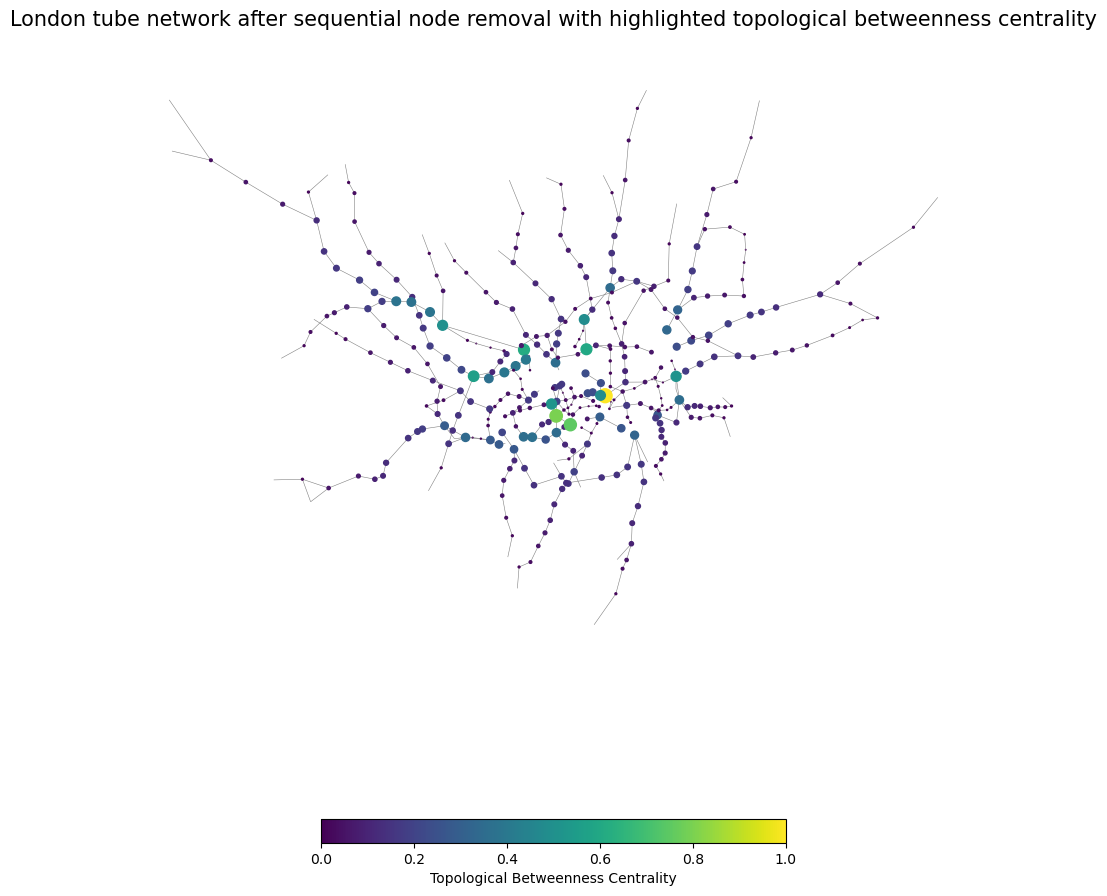

In [31]:
## draw a network graph after 11 most important stations based on topological betweenness centrality
# non-sequential removal

betweenness_t_values=[(i[1]['betweenness_t']) for i in G2_t_bet_ca.nodes(data=True)]
bet_t_color=[(i[1]['betweenness_t']/max(betweenness_t_values)) for i in G2_t_bet_ca.nodes(data=True)]
bet_t_size=[(i[1]['betweenness_t']/max(betweenness_t_values))*100 for i in G2_t_bet_ca.nodes(data=True)]
fig, ax = plt.subplots(figsize=(12,12))
nx.draw_networkx_edges(G2_t_bet_ca, pos,edge_color='gray', 
        width=0.4)
nod=nx.draw_networkx_nodes(G2_t_bet_ca,
        pos = pos,
        node_color= bet_t_color,
        node_size= bet_t_size)
plt.colorbar(nod,label="Topological Betweenness Centrality",orientation="horizontal", shrink=0.5)
plt.axis("off")
plt.title("London tube network after sequential node removal with highlighted topological betweenness centrality",fontsize=15)
#save the plot
plt.savefig('seq_tb_network.png', dpi=300, bbox_inches='tight')

plt.show()

In [32]:
G2_t_clo_st = G.copy() #graph for task 2 degree centrality
G2_t_clo_ca = G.copy() 
close_stationlist = clo_removal_stations(G2_t_clo_st)# get the removal list of the stations
seq_tc = calculation(G2_t_clo_ca,close_stationlist)
seq_tc.insert(0, "remove_stations", close_stationlist)
seq_tc.loc[-1] = ['None (Original network)',36,401, 0.030382,1]
seq_tc.index = seq_tc.index + 1
seq_tc.sort_index(inplace=True) 
seq_tc

Degree_10: [0.11477761836441894, 0.11236271472824556, 0.1046542203523534, 0.09742331288343559, 0.08173374613003095, 0.07597614925947298, 0.0637317773723287, 0.06364466101439217, 0.06043437204910292, 0.05050144516038999]
The removed station is :  Green Park
The removed station is :  King's Cross St. Pancras
The removed station is :  Waterloo
The removed station is :  Bank and Monument
The removed station is :  West Hampstead
The removed station is :  Canada Water
The removed station is :  Stratford
The removed station is :  Earl's Court
The removed station is :  Shepherd's Bush
The removed station is :  Oxford Circus


,remove_stations,diameter,largest component,average clustering coefficient,component_num
0,None (Original network),36,401,0.030382,1
1,Green Park,36,400,0.029792,1
2,King's Cross St. Pancras,38,399,0.030033,1
3,Waterloo,40,398,0.028715,1
4,Bank and Monument,42,397,0.028080,1
5,West Hampstead,50,396,0.028151,1
6,Canada Water,38,226,0.028222,2
7,Stratford,38,226,0.028378,4
8,Earl's Court,39,225,0.021580,4
9,Shepherd's Bush,40,195,0.021635,5


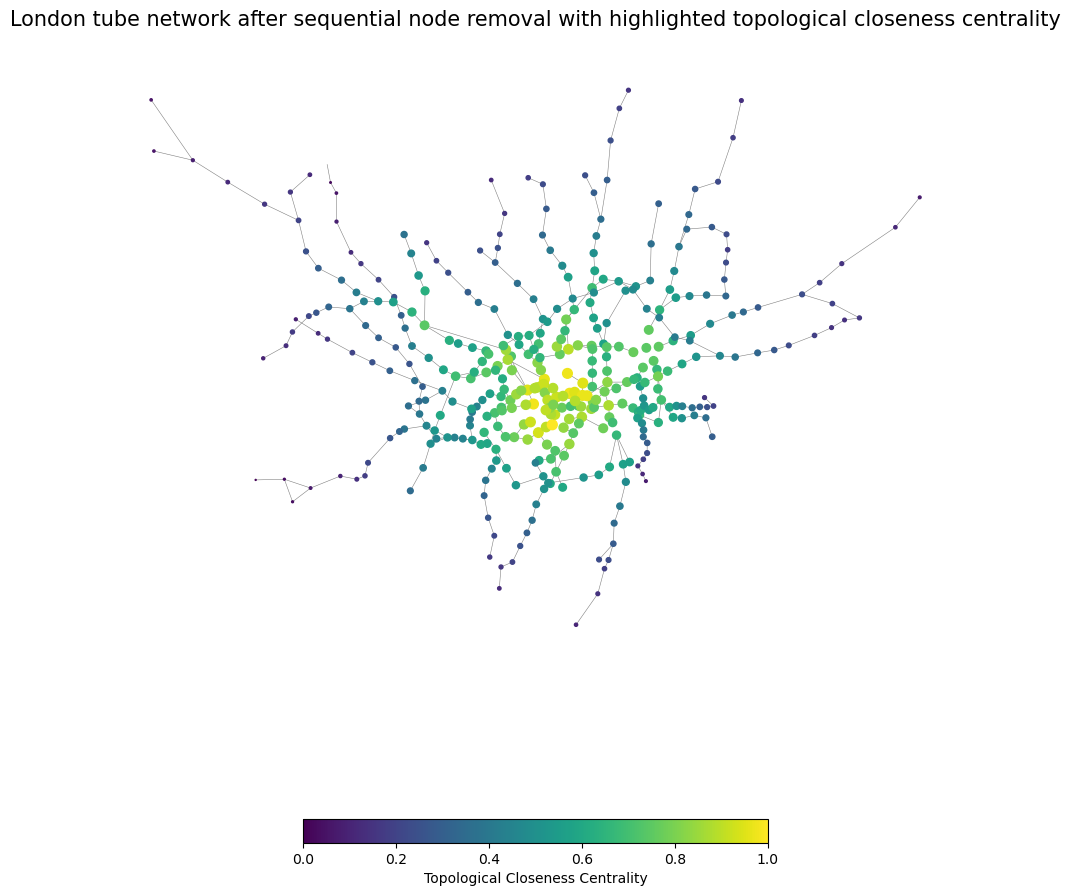

In [33]:
## draw a network graph after 10 most important stations based on topological closeness centrality
# non-sequential removal

clos_t_val=[(i[1]['closeness_t']) for i in G2_t_clo_ca.nodes(data=True)]
closs_t_color=[(i[1]['closeness_t']-min(clos_t_val))/(max(clos_t_val)-min(clos_t_val)) for i in G2_t_clo_ca.nodes(data=True)]
closs_t_size=[((i[1]['closeness_t']-min(clos_t_val))/(max(clos_t_val)-min(clos_t_val))*50) for i in G2_t_clo_ca.nodes(data=True)]
fig, ax = plt.subplots(figsize=(12,12))
nx.draw_networkx_edges(G2_t_clo_ca, pos, edge_color='gray', 
        width=0.4)
nod=nx.draw_networkx_nodes(G2_t_clo_ca,
        pos = pos,
        node_color= closs_t_color,
        node_size= closs_t_size)
plt.colorbar(nod,label="Topological Closeness Centrality",orientation="horizontal", shrink=0.5)
plt.axis("off")
plt.title("London tube network after sequential node removal with highlighted topological closeness centrality",fontsize=15)
#save the plot
plt.savefig('seq_tc_network.png', dpi=300, bbox_inches='tight')

plt.show()

#### Report the line charts in one plot, respectively

In [34]:
# Report the line charts in one plot, respectively: (non-sequential & sequential node removal based on degree centrality)
def plot_chart(ax, df, title):
    ax.set_title(title)
    ax.set_xlabel('Ordered remove stations')
    
    ax1 = ax
    ax1.set_ylabel('Diameter', color='tab:blue')
    line1 = ax1.plot(df['remove_stations'], df['diameter'], color='tab:blue', label='Diameter')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    ax2 = ax1.twinx()
    ax2.set_ylabel('Largest component size', color='tab:red')
    line2 = ax2.plot(df['remove_stations'], df['largest component'], color='tab:red', label='size of the largest component')
    ax2.tick_params(axis='y', labelcolor='tab:red')
#add legend:
    lines = line1 + line2
    labels = [line.get_label() for line in lines]
    ax1.legend(lines, labels, loc=(0.15, -0.75), ncol=2)
    
    ax1.set_xticks(df['remove_stations'])
    ax1.set_xticklabels(df['remove_stations'], rotation=90)

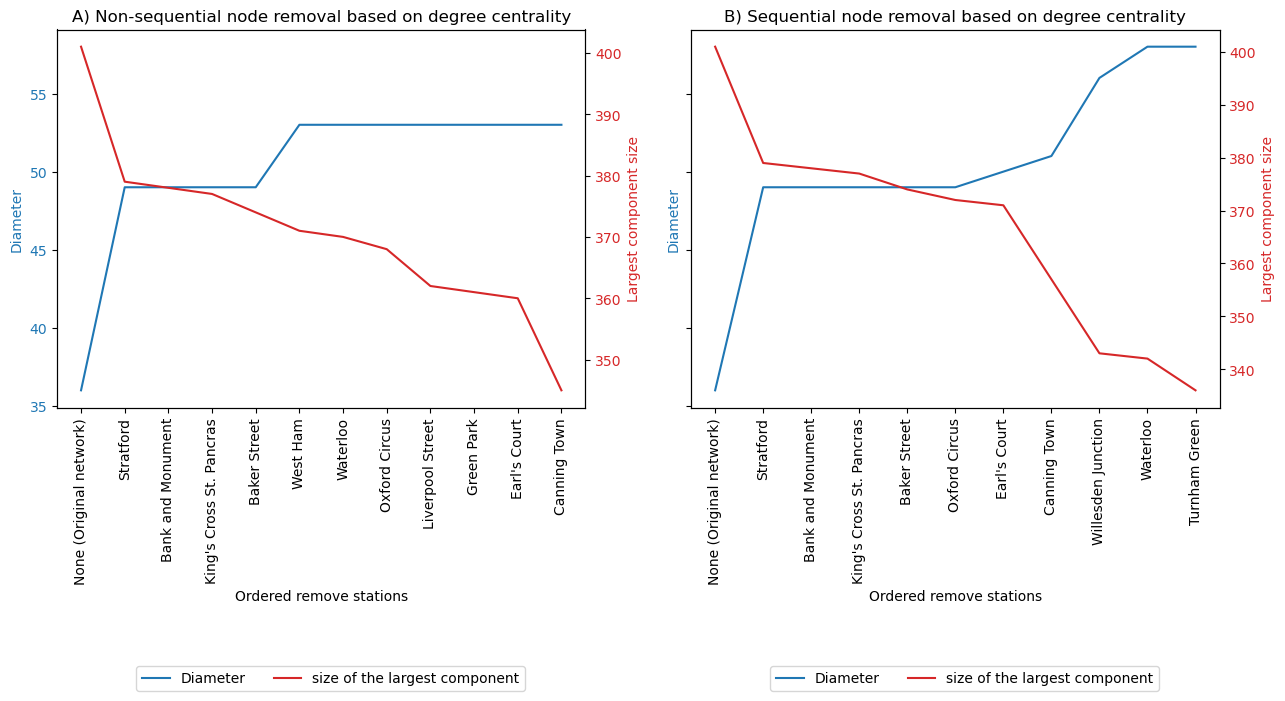

In [35]:
## For non-sequential & sequential node removal based on degree centrality
# Create a figure and a set of subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), sharey=True)
plt.subplots_adjust(bottom=0.25)
# Create the first line chart for df1
plot_chart(ax1, non_seq_dc, 'A) Non-sequential node removal based on degree centrality')

# Create the second line chart for df2
plot_chart(ax2, seq_dc, 'B) Sequential node removal based on degree centrality')

# Ensure the plot is drawn before saving
plt.draw()
# save the plot:
plt.savefig('degree_centrality_removal_plot.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

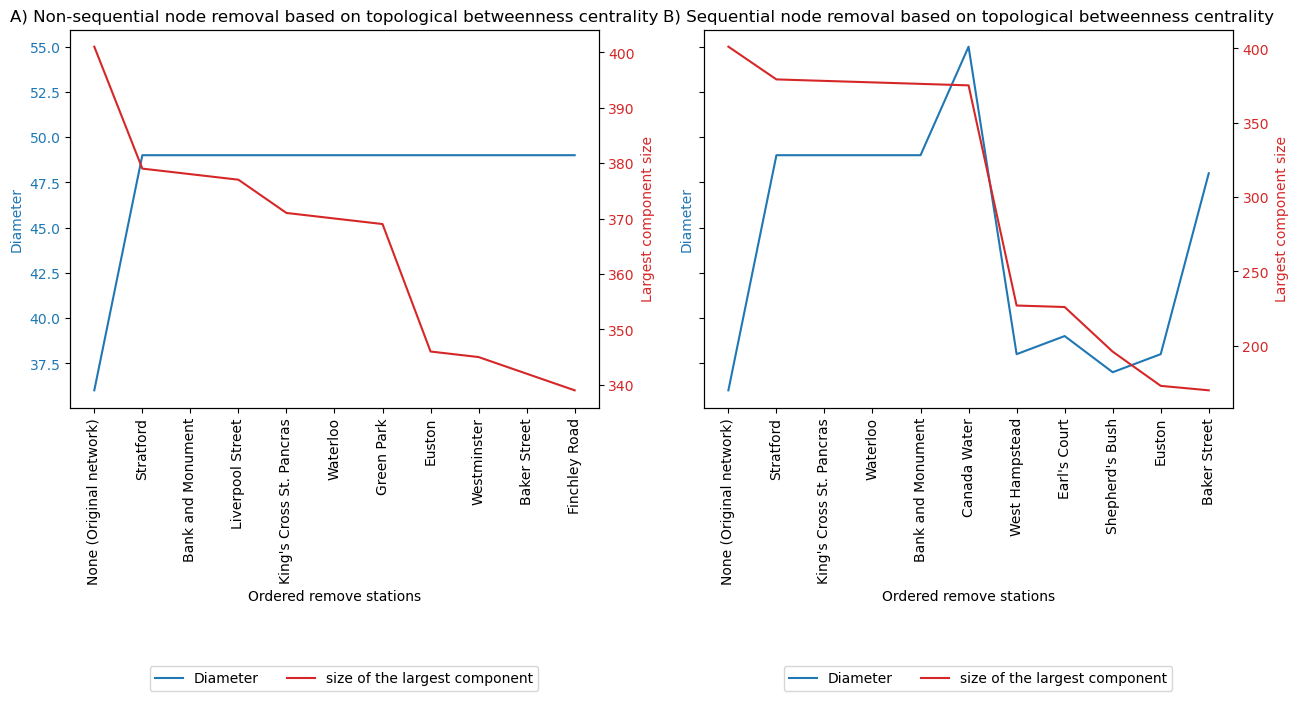

In [36]:
## For non-sequential & sequential node removal based on topological betweenness centrality
# Create a figure and a set of subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), sharey=True)
plt.subplots_adjust(bottom=0.25)
# Create the first line chart for df1
plot_chart(ax1, non_seq_tb, 'A) Non-sequential node removal based on topological betweenness centrality')

# Create the second line chart for df2
plot_chart(ax2, seq_tb, 'B) Sequential node removal based on topological betweenness centrality')

# Ensure the plot is drawn before saving
plt.draw()
#save the plot:
plt.savefig('tb_centrality_removal_plot.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

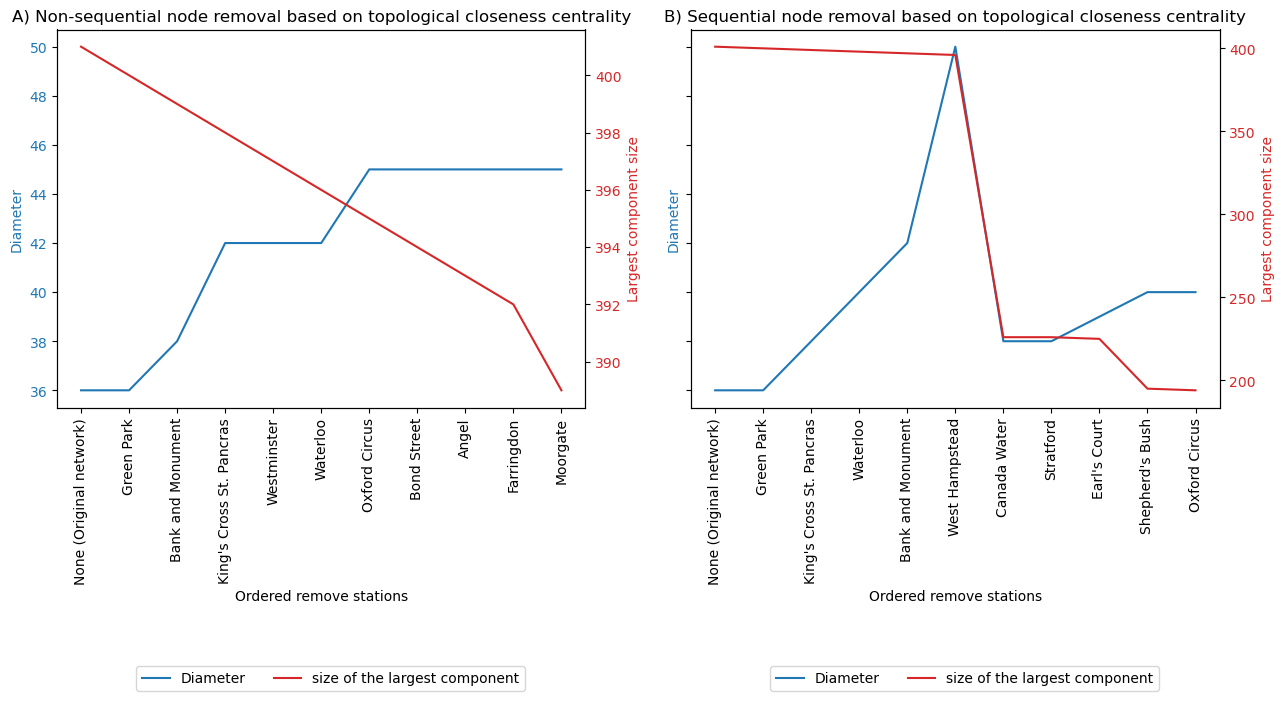

In [37]:
## For non-sequential & sequential node removal based on topological closeness centrality
# Create a figure and a set of subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), sharey=True)
plt.subplots_adjust(bottom=0.25)
# Create the first line chart for df1
plot_chart(ax1, non_seq_tc, 'A) Non-sequential node removal based on topological closeness centrality')

# Create the second line chart for df2
plot_chart(ax2, seq_tc, 'B) Sequential node removal based on topological closeness centrality')

# Ensure the plot is drawn before saving
plt.draw()
#save the plot:
plt.savefig('tc_centrality_removal_plot.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

## Part 1-II Weighted Network

#### II.1.1 Weighted degree centrality

In [64]:
# Calculate weighted degree centrality
weighted_degree_centrality = dict(G.degree(weight='flows'))
num_nodes = G.number_of_nodes()
normalized_weighted_degree_centrality = {node: degree / (num_nodes - 1) for node, degree in weighted_degree_centrality.items()}
normalized_weighted_degree_centrality
nx.set_node_attributes(G,normalized_weighted_degree_centrality,'degree_w')
# To dataframe using the nodes as the index
W_deg_df = pd.DataFrame(index=G.nodes())
W_deg_df['degree_w'] = pd.Series(nx.get_node_attributes(G, 'degree_w'))
W_deg_df_sorted = W_deg_df.sort_values(["degree_w"], ascending=False)
W_deg_top10 = W_deg_df_sorted[0:10]
W_deg_top10.reset_index(inplace = True)
W_deg_top10.rename(columns = {'index':'Stations'},inplace = True)
W_deg_top10

C:\Users\zhaol\AppData\Local\Temp\ipykernel_7908\2133139655.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  W_deg_top10.rename(columns = {'index':'Stations'},inplace = True)


,Stations,degree_w
0,Green Park,1681.8500
1,Bank and Monument,1415.4825
2,Waterloo,1350.2750
3,King's Cross St. Pancras,1205.7375
4,Westminster,1146.3725
5,Liverpool Street,1032.3025
6,Victoria,1025.3650
7,Euston,978.6900
8,Stratford,916.9425
9,Oxford Circus,845.2200


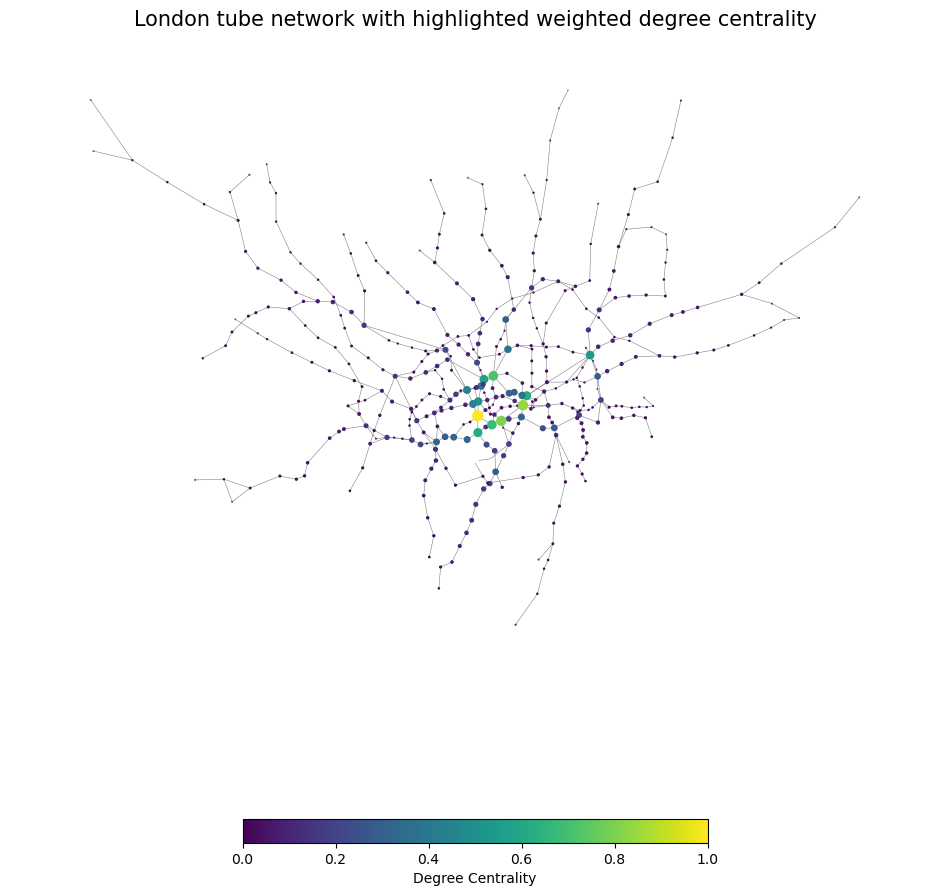

In [107]:
# set colour and size of nodes according to degree centrality values
degree_w_values=[(i[1]['degree_w']) for i in G.nodes(data=True)]
deg_w_color=[(i[1]['degree_w']/(max(degree_w_values))) for i in G.nodes(data=True)]
deg_w_size=[(i[1]['degree_w']/(max(degree_w_values)))*50 for i in G.nodes(data=True)]
# Plot graph
pos=pos
fig, ax = plt.subplots(figsize=(12,12))
nx.draw_networkx_edges(G, pos,edge_color='gray', 
        width=0.4)
nod=nx.draw_networkx_nodes(G,
        pos = pos,
        node_color= deg_w_color,
        node_size= deg_w_size)
plt.colorbar(nod,label="Degree Centrality",orientation="horizontal", shrink=0.5)
plt.axis("off")
plt.title("London tube network with highlighted weighted degree centrality",fontsize=15)
#save:
plt.savefig('w_deg_network.png', dpi=300, bbox_inches='tight')
plt.show()

#### II.1.2 Weighted betweenness centrality

In [66]:
## weighted betweenness centrality:
bet_london_w=nx.betweenness_centrality(G,weight='flows',normalized=True)
nx.set_node_attributes(G,bet_london_w,'betweenness_w')
# To dataframe using the nodes as the index
W_betweenness_df = pd.DataFrame(index=G.nodes())
W_betweenness_df['betweenness_w'] = pd.Series(nx.get_node_attributes(G, 'betweenness_w'))
W_betweenness_df_sorted = W_betweenness_df.sort_values(["betweenness_w"], ascending=False)
W_betweenness_top10 = W_betweenness_df_sorted[0:10]
W_betweenness_top10.reset_index(inplace = True)
W_betweenness_top10.rename(columns = {'index':'Stations'},inplace = True)
W_betweenness_top10

C:\Users\zhaol\AppData\Local\Temp\ipykernel_7908\2291515047.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  W_betweenness_top10.rename(columns = {'index':'Stations'},inplace = True)


,Stations,betweenness_w
0,West Hampstead,0.378076
1,Gospel Oak,0.300977
2,Finchley Road & Frognal,0.291805
3,Hampstead Heath,0.290840
4,Stratford,0.253857
5,Willesden Junction,0.238747
6,Leicester Square,0.220915
7,Brondesbury,0.214502
8,Brondesbury Park,0.213029
9,Kensal Rise,0.211570


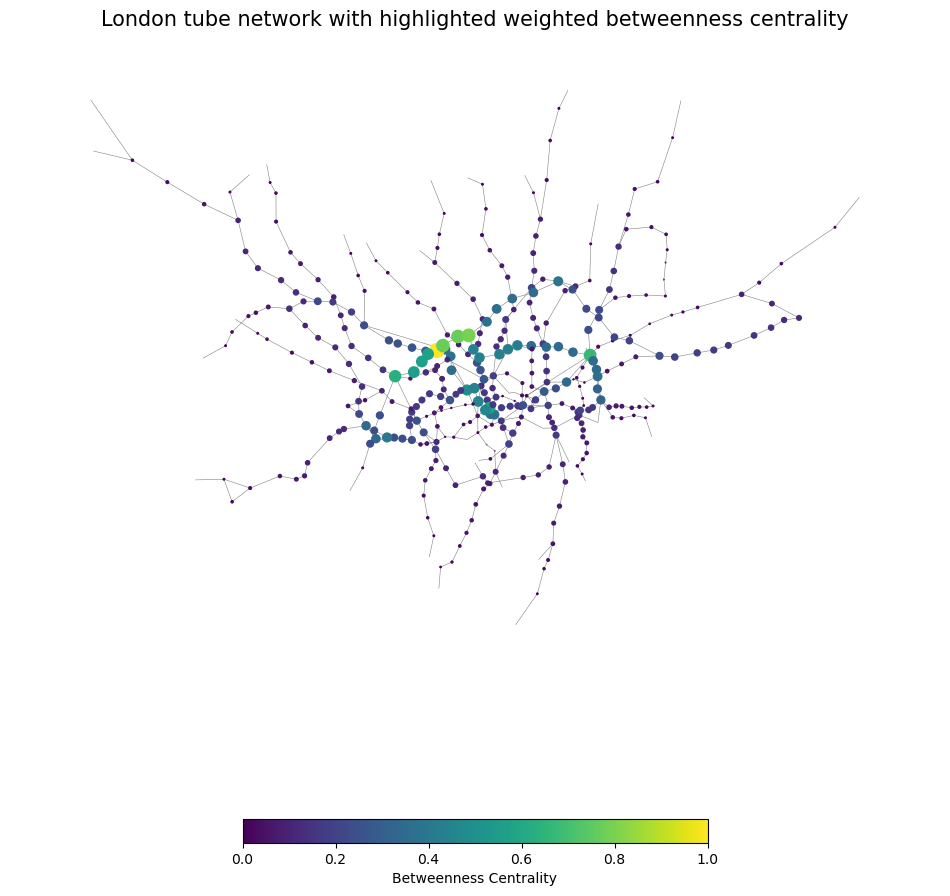

In [108]:
#set colour and size of nodes according to betweenness values
betweenness_w_values=[(i[1]['betweenness_w']) for i in G.nodes(data=True)]
bet_w_color=[(i[1]['betweenness_w']/max(betweenness_w_values)) for i in G.nodes(data=True)]
bet_w_size=[(i[1]['betweenness_w']/max(betweenness_w_values))*100 for i in G.nodes(data=True)]
# Plot graph
fig, ax = plt.subplots(figsize=(12,12))
nx.draw_networkx_edges(G, pos,edge_color='gray', width=0.4)
nod=nx.draw_networkx_nodes(G, pos = pos, node_color= bet_w_color, node_size= bet_w_size)
plt.colorbar(nod,label="Betweenness Centrality",orientation="horizontal", shrink=0.5)
plt.axis("off")
plt.title("London tube network with highlighted weighted betweenness centrality",fontsize=15)

#save:
plt.savefig('w_bet_network.png', dpi=300, bbox_inches='tight')
plt.show()

#### II.1.3 Weighted closeness centrality

In [58]:
#Weighted closeness centrality: 
clos_w=nx.closeness_centrality(G, distance='flows')
nx.set_node_attributes(G,clos_w,'closeness_w')
# To dataframe using the nodes as the index
W_closeness_df = pd.DataFrame(index=G.nodes())
# df['station_name'] = pd.Series(nx.get_node_attributes(G, 'station_name'))
W_closeness_df['closeness_w'] = pd.Series(nx.get_node_attributes(G, 'closeness_w'))
W_closeness_df_sorted = W_closeness_df.sort_values(["closeness_w"], ascending=False)
W_closeness_top10 = W_closeness_df_sorted[0:10]
W_closeness_top10.reset_index(inplace = True)
W_closeness_top10.rename(columns = {'index':'Stations'},inplace = True)
W_closeness_top10
# top 10 results may change, cause too many stations have same values

C:\Users\zhaol\AppData\Local\Temp\ipykernel_7908\134530040.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  W_closeness_top10.rename(columns = {'index':'Stations'},inplace = True)


,Stations,closeness_w
0,West Hampstead,0.000006
1,Finchley Road & Frognal,0.000006
2,Hampstead Heath,0.000006
3,Brondesbury,0.000006
4,Gospel Oak,0.000006
5,Upper Holloway,0.000006
6,Brondesbury Park,0.000006
7,Kentish Town West,0.000006
8,Crouch Hill,0.000006
9,Harringay Green Lanes,0.000006


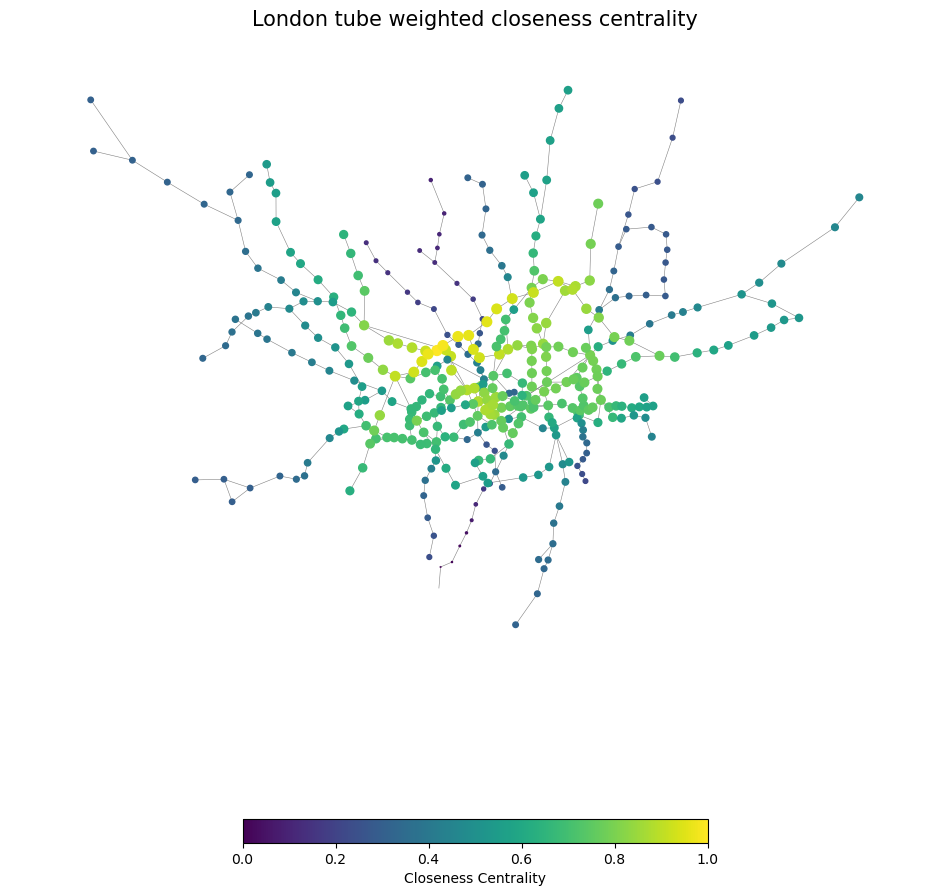

In [94]:
#set color and width of nodes according to the closeness values
clos_w_val=[(i[1]['closeness_w']) for i in G.nodes(data=True)]
closs_w_color=[(i[1]['closeness_w']-min(clos_w_val))/(max(clos_w_val)-min(clos_w_val)) for i in G.nodes(data=True)]
closs_w_size=[((i[1]['closeness_w']-min(clos_w_val))/(max(clos_w_val)-min(clos_w_val))*50) for i in G.nodes(data=True)]
# Plot graph
fig, ax = plt.subplots(figsize=(12,12))
nx.draw_networkx_edges(G, pos,edge_color='gray', 
        width=0.4)
nod=nx.draw_networkx_nodes(G,
        pos = pos,
        node_color= closs_w_color,
        node_size= closs_w_size)
plt.colorbar(nod,label="Closeness Centrality",orientation="horizontal", shrink=0.5)
plt.axis("off")
plt.title("London tube weighted closeness centrality",fontsize=15)
plt.show()

#### II.1.4 weighted eigenvector centrality 

            Stations   w_eigen
0         Green Park  0.513079
1        Westminster  0.476470
2           Waterloo  0.414962
3  Bank and Monument  0.285485
4           Victoria  0.279853
5      Oxford Circus  0.231076
6        Bond Street  0.202825
7   Liverpool Street  0.144792
8      Warren Street  0.090524
9      Sloane Square  0.087789


C:\Users\zhaol\AppData\Local\Temp\ipykernel_7908\2072652401.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  w_eigen_top10.rename(columns = {'index':'Stations'},inplace = True)


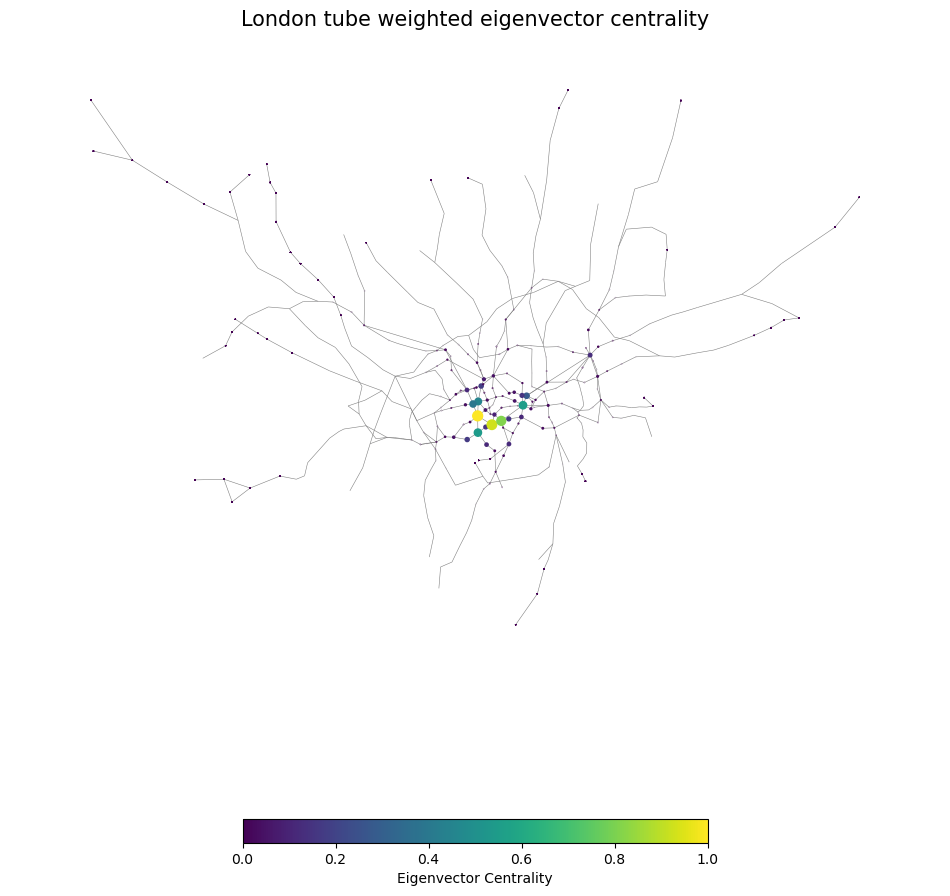

In [106]:
w_eigen = nx.eigenvector_centrality_numpy(G, weight = 'flows')
nx.set_node_attributes(G,w_eigen,'w_eigen')
# To dataframe using the nodes as the index
w_eigen_df = pd.DataFrame(index=G.nodes())
w_eigen_df['w_eigen'] = pd.Series(nx.get_node_attributes(G, 'w_eigen'))
w_eigen_df_sorted = w_eigen_df.sort_values(["w_eigen"], ascending=False)
w_eigen_top10 = w_eigen_df_sorted[0:10]
w_eigen_top10.reset_index(inplace = True)
w_eigen_top10.rename(columns = {'index':'Stations'},inplace = True)
print(w_eigen_top10)

# set colour and size of nodes according to degree centrality values
eigen_w_values=[(i[1]['w_eigen']) for i in G.nodes(data=True)]
# eigen_w_color=[(i[1]['w_eigen']/(max(eigen_w_values))) for i in G.nodes(data=True)]
# eigen_w_size=[(i[1]['w_eigen']/ 1) for i in G.nodes(data=True)]
eigen_w_color=[(i[1]['w_eigen']-min(eigen_w_values))/(max(eigen_w_values)-min(eigen_w_values)) for i in G.nodes(data=True)]
eigen_w_size=[((i[1]['w_eigen']-min(eigen_w_values))/(max(eigen_w_values)-min(eigen_w_values))*50) for i in G.nodes(data=True)]
# Plot graph
pos=pos
fig, ax = plt.subplots(figsize=(12,12))
nx.draw_networkx_edges(G, pos,edge_color='gray', 
        width=0.4)
nod=nx.draw_networkx_nodes(G,
        pos = pos,
        node_color= eigen_w_color,
        node_size= eigen_w_size)
plt.colorbar(nod,label="Eigenvector Centrality",orientation="horizontal", shrink=0.5)
plt.axis("off")
plt.title("London tube weighted eigenvector centrality",fontsize=15)
plt.show()

#### Part II.2 two weighted measures

In [113]:
## Measure 1: total flow:
total_flows = sum(edge_data['flows'] for _, _, edge_data in G.edges(data=True))
total_flows
## Measure 2: the largest component size:


9930847

In [182]:
## Repeat the experiment and evaluate the importance of node removal:
# remove list based on sequential way:
def bet_removal_stations_w(G):
    remove_list = []
    bet_3 = []
    for i in range(3):
        deg_london = nx.betweenness_centrality(G, weight='flows',normalized=True)
        nx.set_node_attributes(G, dict(deg_london), 'w_bet_remove')
        degree_df2_1 = pd.DataFrame()
        degree_df2_1['w_bet_remove'] = pd.Series(nx.get_node_attributes(G, 'w_bet_remove'))
        degree_df2_1.reset_index(inplace=True)
        degree_df2_1.rename(columns={'index': 'Stations'}, inplace=True)
        degree_sorted2_1 = degree_df2_1.sort_values(["w_bet_remove", "Stations"], ascending=False)
        remove_list.append(degree_sorted2_1.iloc[0, 0])
        G.remove_node(degree_sorted2_1.iloc[0, 0])
        bet_3.append(degree_sorted2_1.iloc[0, 1])
        remove_bet = {
            'remove_stations': remove_list,
            'weighted betweenness centrality': bet_3
        }
        remove_bet = pd.DataFrame(remove_bet)
    return remove_bet

def calculation_w(G,stationlist):
#     com_num = []
    L_components = []
    total_flow = []
    num_com = []
    for i in range(len(stationlist)):
        G.remove_node(stationlist[i])
        print("The removed station is : ",stationlist[i])
        num_com.append(nx.number_connected_components(G))
        components = nx.connected_components(G)# Get the list of components
        largest_component = max(components, key=len)# Use the max() command to find the largest one
        Largest_subgraph = G.subgraph(largest_component)# Create a "subgraph" of the largest component
        L_components.append(len(largest_component))
        total_flow.append(sum(edge_data['flows'] for _, _, edge_data in G.edges(data=True)))
    data_dict = {
        'total flows': total_flow,
        'largest component': L_components,
        'component num':num_com
    }
    measure = pd.DataFrame(data_dict)
    return measure

def plot_chart(ax, df, title):
    ax.set_title(title)
    ax.set_xlabel('Ordered remove stations')
    
    ax1 = ax
    ax1.set_ylabel('total flows', color='tab:blue')
    line1 = ax1.plot(df['remove_stations'], df['total flows'], color='tab:blue', label='total flows')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    ax2 = ax1.twinx()
    ax2.set_ylabel('Largest component size', color='tab:red')
    line2 = ax2.plot(df['remove_stations'], df['largest component'], color='tab:red', label='size of the largest component')
    ax2.tick_params(axis='y', labelcolor='tab:red')
#add legend:
    lines = line1 + line2
    labels = [line.get_label() for line in lines]
    ax1.legend(lines, labels, loc=(0.15, -0.75), ncol=2)
    
    ax1.set_xticks(df['remove_stations'])
    ax1.set_xticklabels(df['remove_stations'], rotation=90)

In [183]:
G_w_bet_st=G.copy() #graph for topological betweenness centrality
G_w_bet_ca=G.copy()
seq_w_bet_remove = bet_removal_stations_w(G_w_bet_st)# get the removal list of the stations
seq_w_bet = calculation_w(G_w_bet_ca,seq_w_bet_remove.iloc[:,0].to_list())
seq_w_bet = pd.concat ([seq_w_bet_remove,seq_w_bet], axis = 1)
seq_w_bet.loc[-1] = ['None (Original network)','not applicable',9930847,401,1]
seq_w_bet.index = seq_w_bet.index + 1
seq_w_bet.sort_index(inplace=True) 
seq_w_bet
# seq_w_bet_remove

The removed station is :  West Hampstead
The removed station is :  Leicester Square
The removed station is :  Oxford Circus


,remove_stations,weighted betweenness centrality,total flows,largest component,component num
0,None (Original network),not applicable,9930847,401,1
1,West Hampstead,0.378076,9879068,400,1
2,Leicester Square,0.405776,9861482,399,1
3,Oxford Circus,0.334032,9523394,398,1


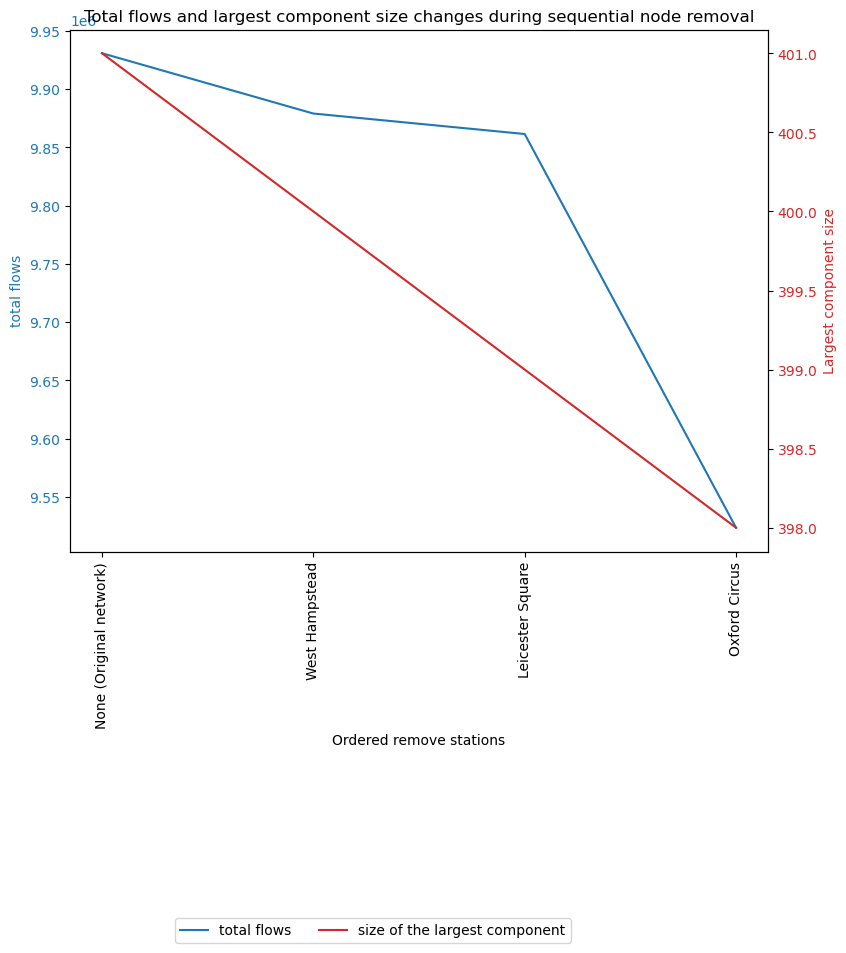

In [184]:
# plot the line chart:
fig, ax1 = plt.subplots(1, 1, figsize=(9,9), sharey=True)
plt.subplots_adjust(bottom=0.3)
# Create the first line chart for df1
plot_chart(ax1, seq_w_bet, 'Total flows and largest component size changes during sequential node removal')

# Ensure the plot is drawn before saving
plt.draw()
#save the plot:
plt.savefig('bet_w_seq_removal_plot.png', dpi=300, bbox_inches='tight')
# Show the plot
plt.show()

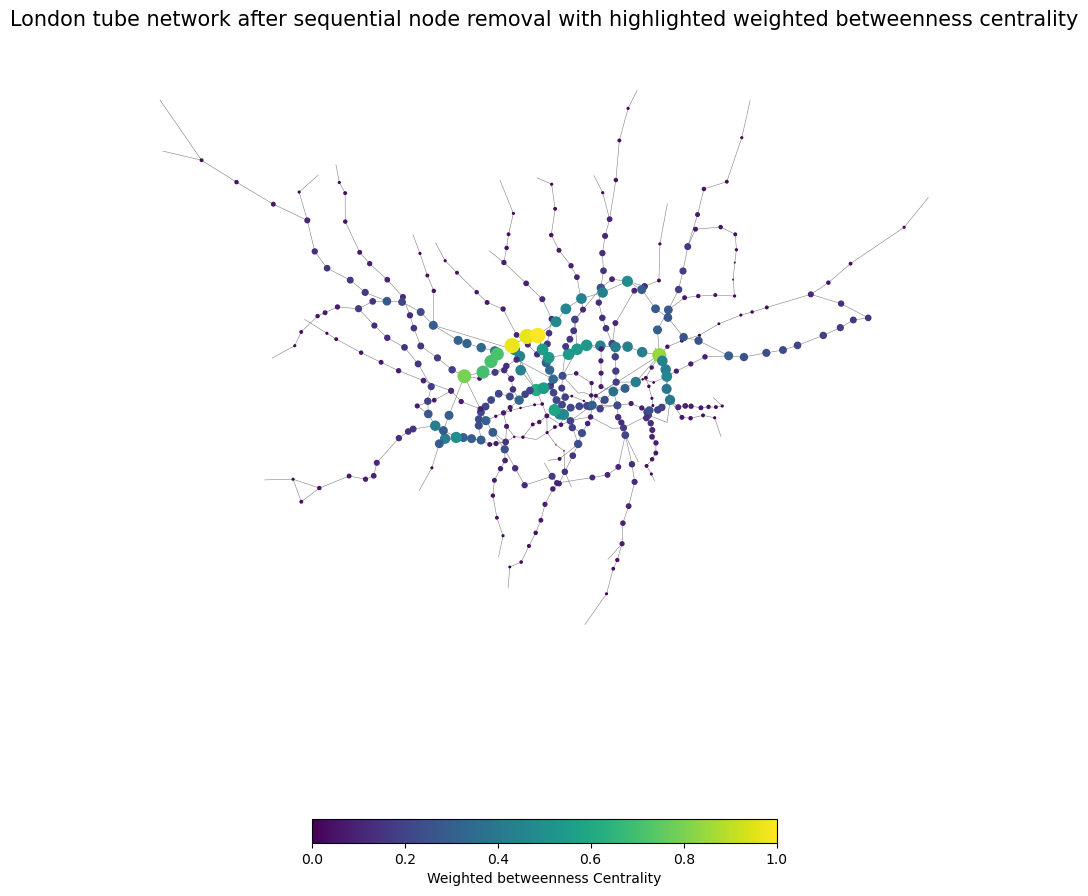

In [165]:
# draw the network after 3 important nodes removed:
bet_w_values=[(i[1]['betweenness_w']) for i in G_w_bet_ca.nodes(data=True)]
bet_w_color=[(i[1]['betweenness_w']/max(bet_w_values)) for i in G_w_bet_ca.nodes(data=True)]
bet_w_size=[(i[1]['betweenness_w']/max(bet_w_values))*100 for i in G_w_bet_ca.nodes(data=True)]
fig, ax = plt.subplots(figsize=(12,12))
nx.draw_networkx_edges(G_w_bet_ca, pos,edge_color='gray', 
        width=0.4)
nod=nx.draw_networkx_nodes(G_w_bet_ca,
        pos = pos,
        node_color= bet_w_color,
        node_size= bet_w_size)
plt.colorbar(nod,label="Weighted betweenness Centrality",orientation="horizontal", shrink=0.5)
plt.axis("off")
plt.title("London tube network after sequential node removal with highlighted weighted betweenness centrality",fontsize=15)
#save the plot
plt.savefig('seq_tbw_network.png', dpi=300, bbox_inches='tight')

plt.show()